In [11]:
import numpy as np
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

# Khởi tạo một số hàm khử nhiễu dao động
def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    E=eye(m,format='csc')
    for i in range(differences):
        E=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*E.T*E))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z


# Sinh dữ liệu

In [2]:
def poly_baseline(x):
    # Tạo các giá trị x từ 0 đến 1024
    p = np.random.uniform(1, 3)  # Đặt bậc của đa thức trong khoảng từ 1 đến 3
    intensity = np.random.uniform(0.5, 1)  # Đặt độ lớn của biên độ trong khoảng từ 0.5 đến 1
    b = np.random.uniform(-0.5, 0.5)  # Đặt độ lệch trong khoảng từ -0.5 đến 0.5

    y = (x / len(x)) ** p + b
    return y * intensity / max(y)

def gaussian_baseline(x):
    mean = np.random.uniform(0, 880)  # Đặt trung bình trong khoảng từ 0 đến 800
    sd = np.random.uniform(100, 600)  # Đặt độ lệch chuẩn trong khoảng từ 100 đến 600
    intensity = np.random.uniform(0.5, 1)  # Đặt độ lớn của biên độ trong khoảng từ 0.5 đến 1
    b = np.random.uniform(-0.5, 0.5)  # Đặt độ lệch trong khoảng từ -0.5 đến 0.5

    y = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y * intensity / max(y)

def trigonometric_baseline(x):
    p = np.random.uniform(10, 8*np.pi)
    intensity = np.random.uniform(0, 1)
    y=np.sin(p*x/len(x))
    return intensity*y/max(y)+intensity

def generate_spectrum(input, num_baselines=2):
    x_range = np.linspace(0,input.shape[0], input.shape[0])
    baseline_labels = np.random.randint(0, 2, size=num_baselines)  # Generate random baseline labels

    baselines = [poly_baseline, gaussian_baseline]

    noisy_spectrum = input / np.max(input)
    spectrum = input / np.max(input)
    baselines_applied = []
    for i in range(num_baselines):
        if baseline_labels[i] == 1:
            baseline_func = baselines[i]
            baseline = baseline_func(x_range)
            baseline = baseline.reshape((-1,1))
            noisy_spectrum += baseline
    
    baselines_applied.append(noisy_spectrum - spectrum)
    baselines_applied = np.array(baselines_applied)
    return noisy_spectrum, baseline_labels, baselines_applied

In [40]:
import pandas as pd
import numpy as np
# Tạo dữ liệu cho 20,000 mẫu
num_samples = 10000
all_noisy_spectra = []
all_baseline_labels = []
all_baseline_applied = []

# Load dataset
Input_Data = './data/dataset_test_01104.npy'

Inputs = np.load(Input_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
for inputs in Inputs:
    noisy_spectrum, baseline_labels, baseline_applied = generate_spectrum(inputs[1, : , :], num_baselines=2)
    all_baseline_labels.append(baseline_labels)  # Sử dụng np.ravel() để biến mảng thành mảng một chiều
    all_noisy_spectra.append(noisy_spectrum.flatten())  # Sử dụng np.ravel() để biến mảng thành mảng một chiều
    all_baseline_applied.append(baseline_applied.flatten())

# Chuyển đổi danh sách thành mảng numpy
all_baseline_labels = np.array(all_baseline_labels)
all_noisy_spectra = np.array(all_noisy_spectra)
all_baseline_applied = np.array(all_baseline_applied)

# Tạo DataFrame từ dữ liệu
df_labels = pd.DataFrame(all_baseline_labels)  # Tạo DataFrame cho labels
df_spectra = pd.DataFrame(all_noisy_spectra)  # Tạo DataFrame cho dữ liệu spectrum
df_basline = pd.DataFrame(all_baseline_applied)

# Kết hợp DataFrame cho labels và dữ liệu spectrum
df = pd.concat([df_labels, df_spectra, df_basline], axis=1)

# Lưu DataFrame vào file CSV
df.to_csv('./data/Baseline_noise_01104.csv', index=False)
print("ok")

ok


In [42]:
import pandas as pd

# Tạo dữ liệu cho 20,000 mẫu
num_samples = 10000
all_noisy_spectra = []
all_baseline_labels = []
all_baseline_applied = []

# Load dataset
Input_Data = './data/dataset_test_01104.npy'

Inputs = np.load(Input_Data)
Inputs = Inputs.reshape(-1, Inputs.shape[2], Inputs.shape[3], Inputs.shape[4])
for inputs in Inputs:
    noisy_spectrum, baseline_labels, baseline_applied = generate_spectrum(inputs[1, : , :], num_baselines=2)
    all_baseline_labels.append(baseline_labels)  # Sử dụng np.ravel() để biến mảng thành mảng một chiều
    all_noisy_spectra.append(noisy_spectrum.flatten())  # Sử dụng np.ravel() để biến mảng thành mảng một chiều
    all_baseline_applied.append(baseline_applied.flatten())

# Chuyển đổi danh sách thành mảng numpy
all_baseline_labels = np.array(all_baseline_labels)
all_noisy_spectra = np.array(all_noisy_spectra)
all_baseline_applied = np.array(all_baseline_applied)

print(all_baseline_applied.shape)
# Tạo DataFrame từ dữ liệu
df_labels = pd.DataFrame(all_baseline_labels)  # Tạo DataFrame cho labels
df_spectra = pd.DataFrame(all_noisy_spectra)  # Tạo DataFrame cho dữ liệu spectrum
df_basline = pd.DataFrame(all_baseline_applied)
# Kết hợp DataFrame cho labels và dữ liệu spectrum
df = pd.concat([df_labels, df_spectra, df_basline], axis=1)

# Lưu DataFrame vào file CSV
df.to_csv('./data/Baseline_test_01104.csv', index=False)
print('ok')

(300, 880)
ok


In [1]:
import pandas as pd
import tensorflow as tf
# Đọc dữ liệu từ tệp CSV vào DataFrame, bỏ qua dòng đầu tiên
df = pd.read_csv("./data/Baseline_noise_01104.csv", skiprows=1, header=None)

# Chuyển đổi DataFrame thành mảng numpy
data_array = df.values

print("Đọc dữ liệu")
# Tách nhãn từ dữ liệu
y_train = data_array[:, :2]
y_train = tf.cast(y_train, tf.float32)

# Tách dữ liệu vào x_train
x_train = data_array[:, 2:882]
baseline_train = data_array[:, 882:]

# Hiển thị kích thước của x_train và y_train+
print("Kích thước x_train:", x_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kích thước baseline_train:", baseline_train.shape)

2024-06-22 02:43:17.243837: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 02:43:17.695296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 02:43:18.607495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Đọc dữ liệu


2024-06-22 02:43:19.972335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 02:43:20.241357: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 02:43:20.241404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 02:43:20.248297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 02:43:20.248340: I external/local_xla/xla/stream_executor

Kích thước x_train: (300, 880)
Kích thước y_train: (300, 2)
Kích thước baseline_train: (300, 880)


In [4]:
def ConvClassifica():
    input = tf.keras.layers.Input((880,))
    input_reshaped = tf.keras.layers.Reshape((880, 1))(input)  # Thêm lớp Reshape để tạo ra kích thước (None, 1024, 1)
    conv1 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, activation='relu')(input_reshaped)
    pool1 = tf.keras.layers.AveragePooling1D(pool_size=2, strides=2)(conv1)
    flatten = tf.keras.layers.Flatten()(pool1)
    fc1 = tf.keras.layers.Dense(100, activation='relu')(flatten)
    fc2 = tf.keras.layers.Dense(2, activation='sigmoid')(fc1)  # Số lượng đầu ra là 4
    model = tf.keras.Model(inputs=input, outputs=fc2)
    return model

# Tạo một thể hiện của mạng ConvClassifica
model = ConvClassifica()

# Kiểm tra kiến trúc của mô hình TensorFlow

model.summary()

#load trọng số
model.load_weights("./model.weights.h5")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 880)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 880, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 876, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 438, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7008)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       700,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 701,198 (2.67 MB)

 Trainable params: 701,198 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
import tensorflow as tf
spectra_num = len(x_train)
train_split = round(0.9 * spectra_num)
val_split = round(0.1 * spectra_num)

x_trainn = x_train[:train_split]
x_test = x_train[train_split:train_split+val_split]

y_trainn = y_train[:train_split]
y_test = y_train[train_split:train_split+val_split]
# Tạo Dataset cho dữ liệu huấn luyện
train_dataset = tf.data.Dataset.from_tensor_slices((x_trainn, y_trainn)).batch(64)

# Tạo Dataset cho dữ liệu kiểm tra
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Train 
# # Tạo mô hình
# model = ConvClassifica()
# import tensorflow.keras.backend as K
# 
# def Custom_Hamming_Loss(y_true, y_pred):
#   return K.mean(y_true*(1-y_pred)+(1-y_true)*y_pred)
# 
# def Custom_Hamming_Loss1(y_true, y_pred):
#   tmp = K.abs(y_true-y_pred)
#   return K.mean(K.cast(K.greater(tmp,0.5),dtype=float))
# 
# # Biên dịch mô hình với optimizer và Hamming loss function
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy',Custom_Hamming_Loss, Custom_Hamming_Loss1])
# 
# # Huấn luyện mô hình
# history = model.fit(train_dataset, validation_data=test_dataset, epochs=35)
# model.save_weights('./model.weights.h5')

In [6]:
# Chọn một mẫu dữ liệu từ x_train
sample_index = 55
sample_data = x_train[sample_index]

# Chuẩn bị mẫu dữ liệu này để phù hợp với đầu vào của mô hình
sample_data = tf.expand_dims(sample_data, axis=0)  # Thêm chiều batch

# Sử dụng mô hình để dự đoán đầu ra cho mẫu dữ liệu đã chọn
predicted_output = model.predict(sample_data)
print("Ground True output for sample", y_train[sample_index])
print("Predicted output for sample", sample_index, ":", predicted_output)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Ground True output for sample tf.Tensor([0. 0.], shape=(2,), dtype=float32)
Predicted output for sample 55 : [[1.4947872e-10 1.3806681e-14]]


In [13]:
import numpy as np
from scipy.optimize import curve_fit

def poly_baseline(x, p, intensity, b):
    y = (x / len(x)) ** p + b
    return y * intensity / max(y)

def gaussian_baseline(x, mean, sd, intensity, b):
    y = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y * intensity / max(y)

def pg_baseline(x, p, in1, mean, sd, in2, b):
    y1 = (x / len(x)) ** p + b
    y2 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y1 / max(y1) * in1 + y2 / max(y2) * in2

def mix_min(sp, baseline ,Previous_Dev):
    # new_baseline = np.minimum(baseline,sp)
    condition1 = (sp > baseline)
    condition1_2 = (sp < baseline + Previous_Dev)
    condition2_2 = (baseline - Previous_Dev < sp)
    # new_baseline = np.where(sp < baseline + Previous_Dev, sp, baseline + Previous_Dev)
    new_baseline = np.where(condition1, np.where(condition1_2, sp, baseline + Previous_Dev), np.where(condition2_2, baseline - Previous_Dev, sp))

    return new_baseline

def iterative_fitting_with_bounds(sp, ite):
    # Initialize the baseline
    fitted_baseline = np.zeros(880)
    #The bounds is in data_generatorf2.R
    x = np.linspace(1, 880, 880)
    tempb = sp
    torch_tempb = tf.expand_dims(tempb, axis=0)
    i = 0
    tem = []
    Previous_Dev = 0
    while i < ite:
        tadvice = model(torch_tempb)
        if i > 0:
            Previous_Dev = Dev
        if tadvice[0][0] >= 0.5 and tadvice[0][1] >= 0.5:
            p, c = curve_fit(pg_baseline, x, tempb, bounds=([1,0.5,0,100,0.5,-0.5],[3,1,880,600,1,0.5]), maxfev=100000)
            fitted_baseline = pg_baseline(x, p[0], p[1], p[2], p[3], p[4], p[5])
        elif tadvice[0][0] >= 0.5:
            p, c = curve_fit(poly_baseline, x, tempb, bounds=([1,0.5,-0.5],[3,1,0.5]),  maxfev=100000)
            fitted_baseline = poly_baseline(x, p[0], p[1], p[2])
        elif tadvice[0][1] >= 0.5:
            p, c = curve_fit(gaussian_baseline, x, tempb, bounds=([0,100,0.5,-0.5],[880,600,1,0.5]),  maxfev=100000)
            fitted_baseline = gaussian_baseline(x, p[0], p[1], p[2], p[3])
        Dev = np.std(tempb-fitted_baseline)
        tempb = mix_min(sp, fitted_baseline, Dev)
        tem.append(tempb)
        # Convert to numpy array
        tempb_np = np.array(tempb)
        # Convert to tensor
        torch_tempb = tempb_np.reshape(1, 880)   
        i += 1
        if i >= 1:
            if np.abs((Dev-Previous_Dev)/Dev) < 0.005:
                break
    tadvice = model(torch_tempb)
    if tadvice[0][0] >= 0.5 and tadvice[0][1] >= 0.5:
                    p, c = curve_fit(pg_baseline, x, tempb, bounds=([1,0.5,0,100,0.5,-0.5],[3,1,880,600,1,0.5]),  maxfev=100000)
                    fitted_baseline = pg_baseline(x, p[0], p[1], p[2], p[3], p[4], p[5])
    elif tadvice[0][0] >= 0.5:
                    p, c = curve_fit(poly_baseline, x, tempb, bounds=([1,0.5,-0.5],[3,1,0.5]),  maxfev=100000)
                    fitted_baseline = poly_baseline(x, p[0], p[1], p[2])
    elif tadvice[0][1] >= 0.5:
                    p, c = curve_fit(gaussian_baseline, x, tempb, bounds=([0,100,0.5,-0.5],[880,600,1,0.5]), maxfev=100000)
                    fitted_baseline = gaussian_baseline(x, p[0], p[1], p[2], p[3])
    tempb_1 = fitted_baseline
    return tempb_1

In [14]:
import numpy as np
from scipy.optimize import curve_fit

def poly_baseline(x, p, intensity, b):
    y = (x / len(x)) ** p + b
    return y * intensity / max(y)

def gaussian_baseline(x, mean, sd, intensity, b):
    y = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y * intensity / max(y)

def pg_baseline(x, p, in1, mean, sd, in2, b):
    y1 = (x / len(x)) ** p + b
    y2 = np.exp(-(x - mean) ** 2 / (2 * sd ** 2)) / (sd * np.sqrt(2 * np.pi)) + b
    return y1 / max(y1) * in1 + y2 / max(y2) * in2

def mix_min_no(sp, baseline):
    new_baseline = np.minimum(baseline,sp)    
    return new_baseline


def iterative_fitting_with_bounds_no(sp, ite):
    # Initialize the baseline
    fitted_baseline = np.zeros(880)
    #The bounds is in data_generatorf2.R
    x = np.linspace(1, 880, 880)
    tempb = sp
    torch_tempb = tf.expand_dims(tempb, axis=0)
    i = 0
    tem = []
    while i < ite:
        tadvice = model(torch_tempb)
        if tadvice[0][0] >= 0.5 and tadvice[0][1] >= 0.5:
            p, c = curve_fit(pg_baseline, x, tempb, bounds=([1,0.5,0,100,0.5,-0.5],[3,1,880,600,1,0.5]), maxfev=100000)
            fitted_baseline = pg_baseline(x, p[0], p[1], p[2], p[3], p[4], p[5])
        elif tadvice[0][0] >= 0.5:
            p, c = curve_fit(poly_baseline, x, tempb, bounds=([1,0.5,-0.5],[3,1,0.5]),  maxfev=100000)
            fitted_baseline = poly_baseline(x, p[0], p[1], p[2])
        elif tadvice[0][1] >= 0.5:
            p, c = curve_fit(gaussian_baseline, x, tempb, bounds=([0,100,0.5,-0.5],[880,600,1,0.5]),  maxfev=100000)
            fitted_baseline = gaussian_baseline(x, p[0], p[1], p[2], p[3])
        tempb = mix_min_no(tempb, fitted_baseline)
        tem.append(tempb)
        # Convert to numpy array
        tempb_np = np.array(tempb)
        # Convert to tensor
        torch_tempb = tempb_np.reshape(1, 880)   
        i += 1

    return tempb

In [11]:
!pip install BaselineRemoval

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Đọc dữ liệu


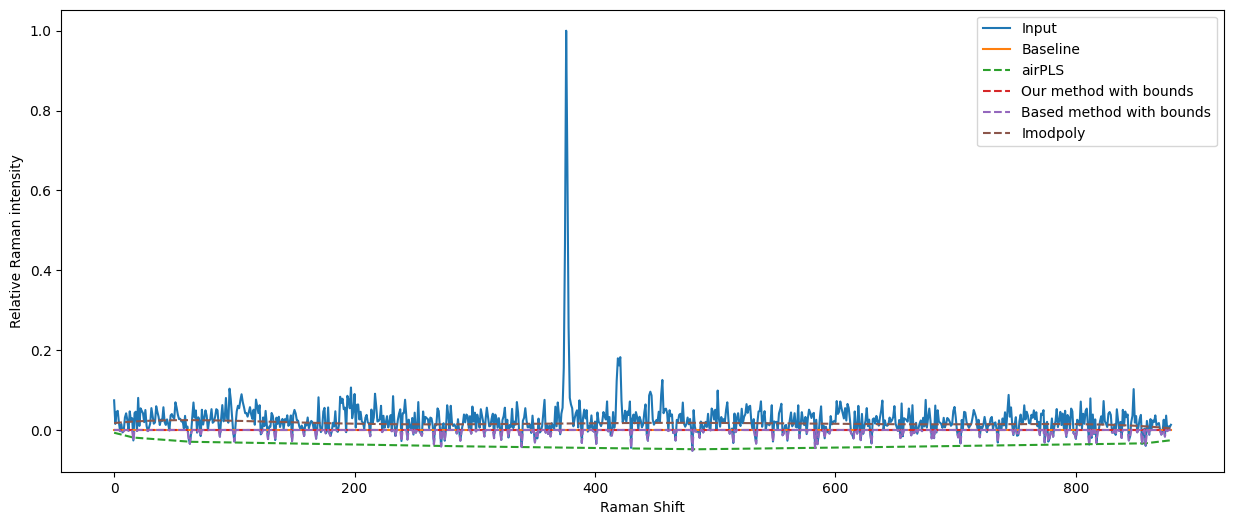

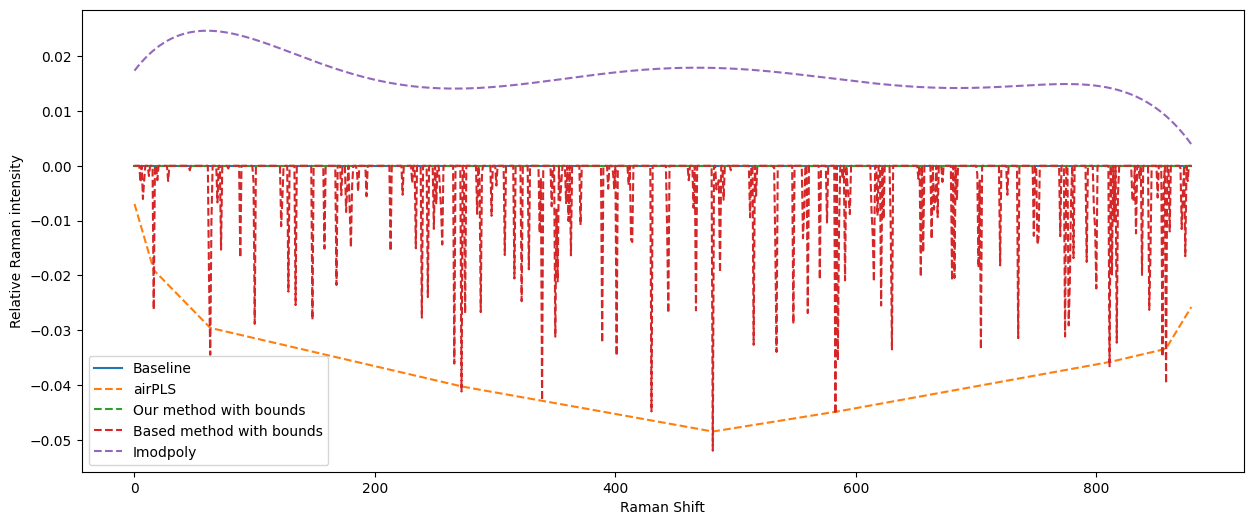

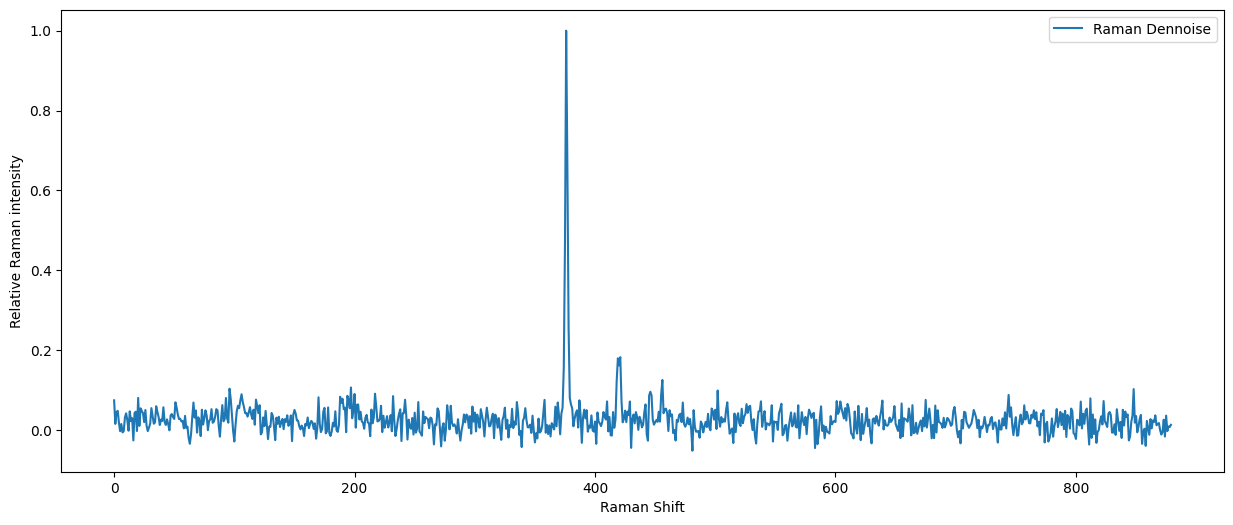

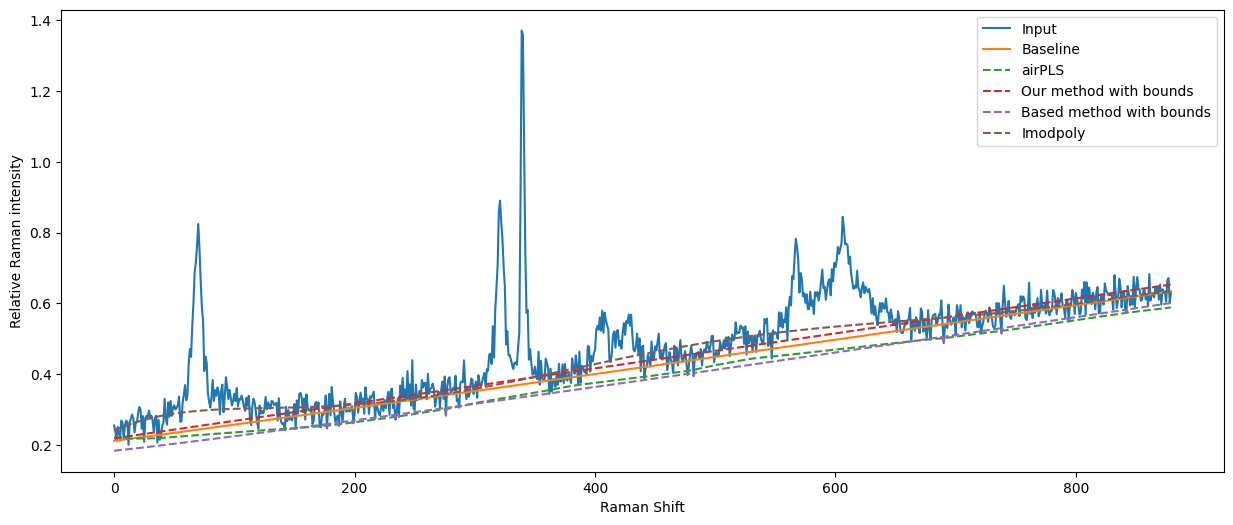

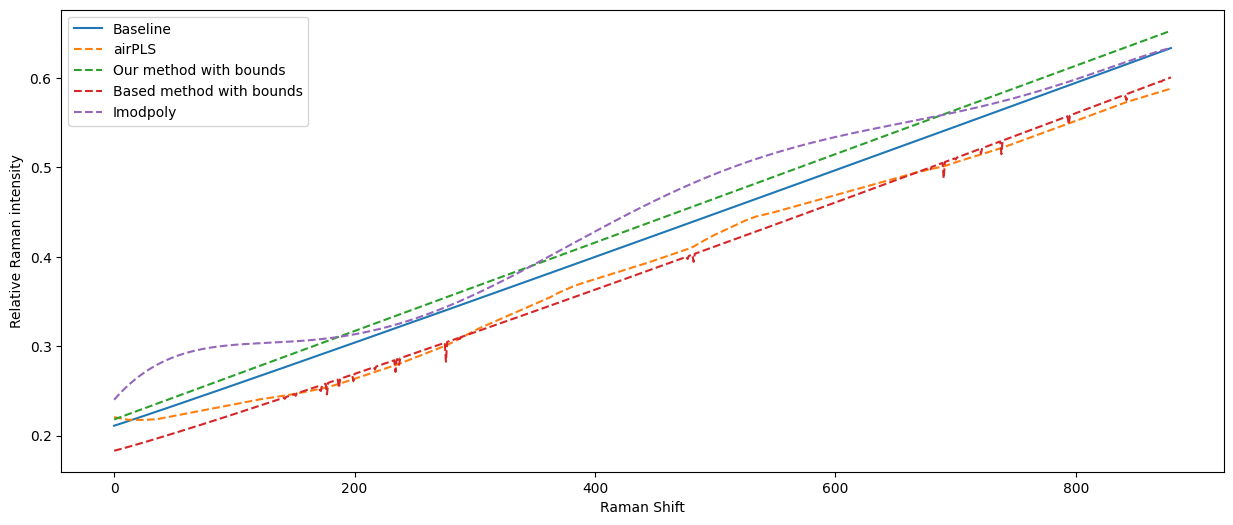

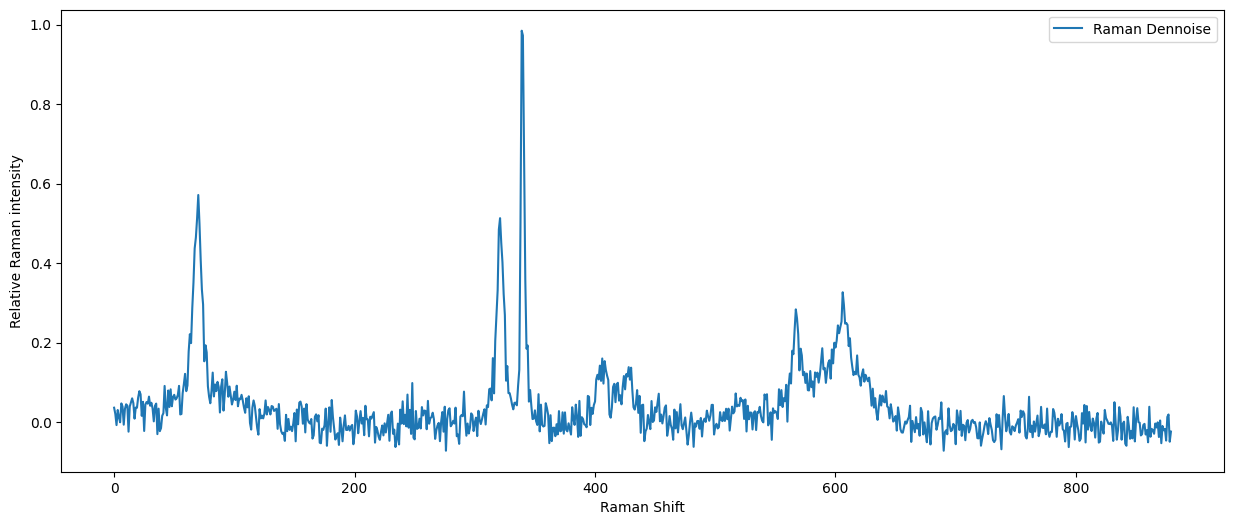

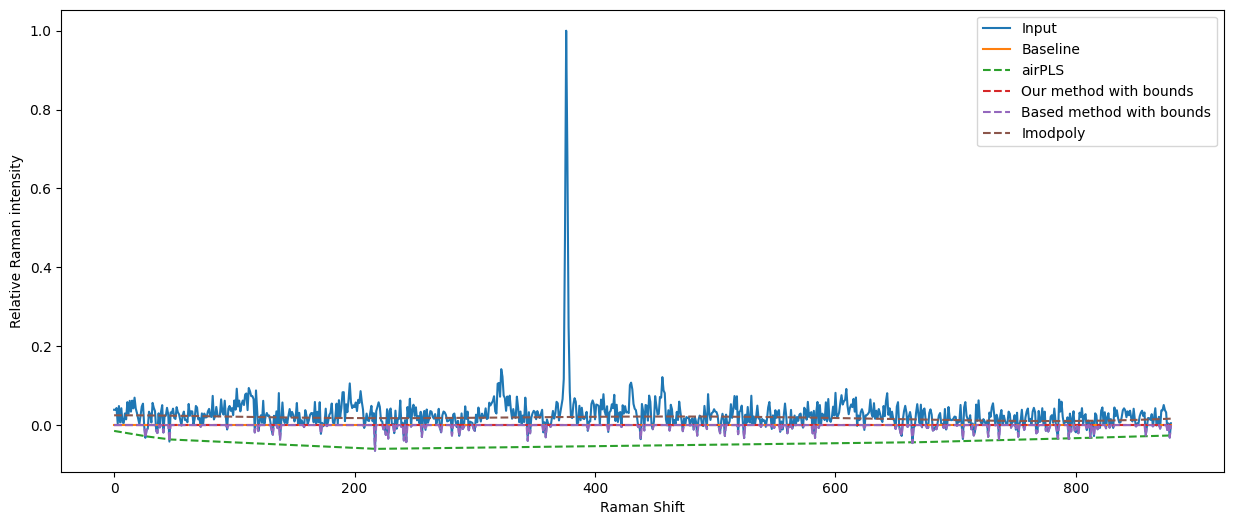

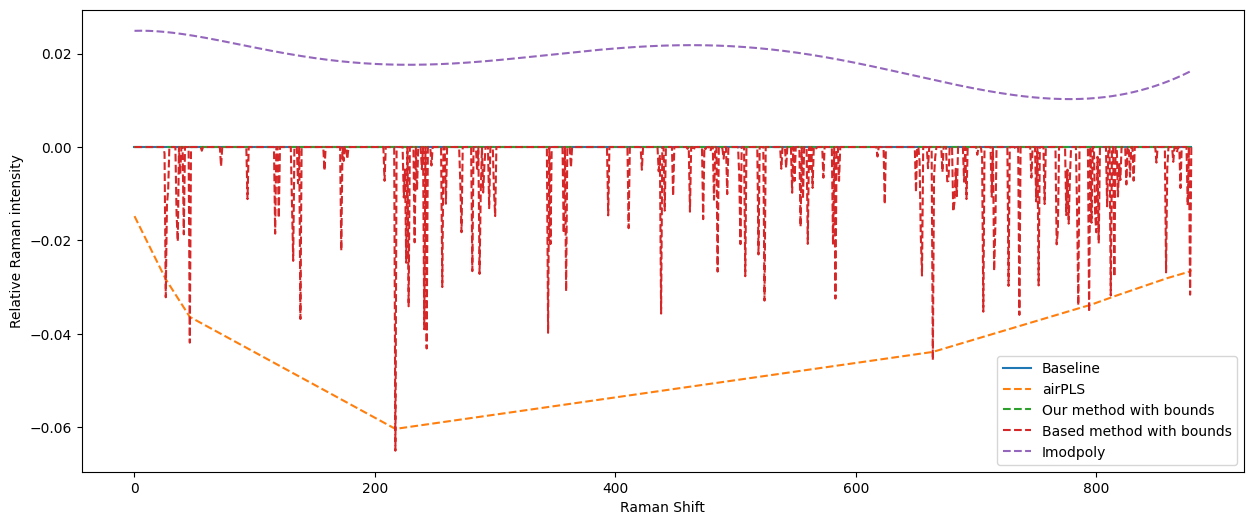

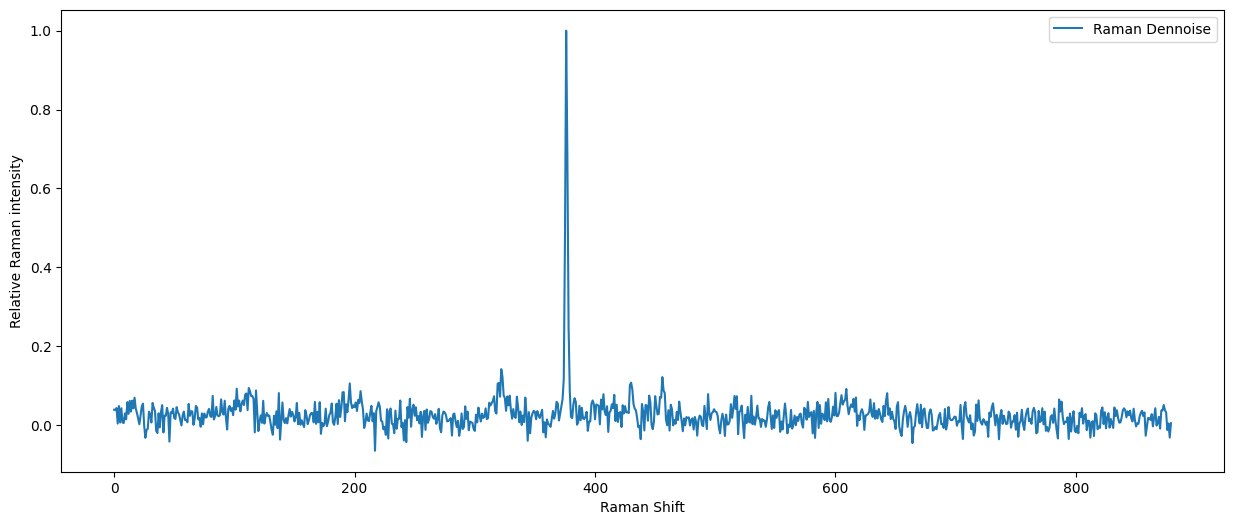

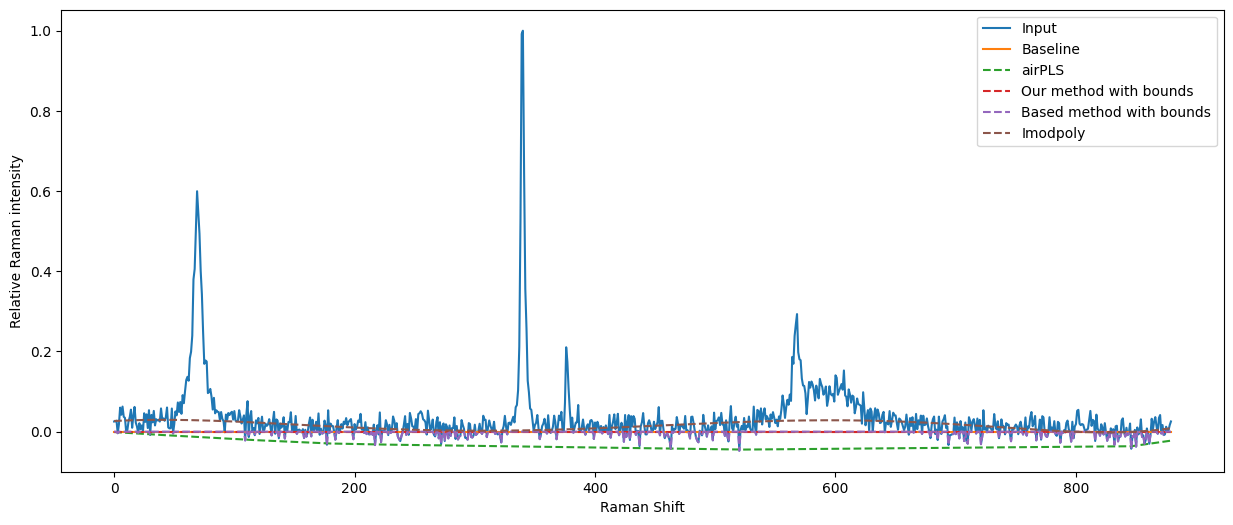

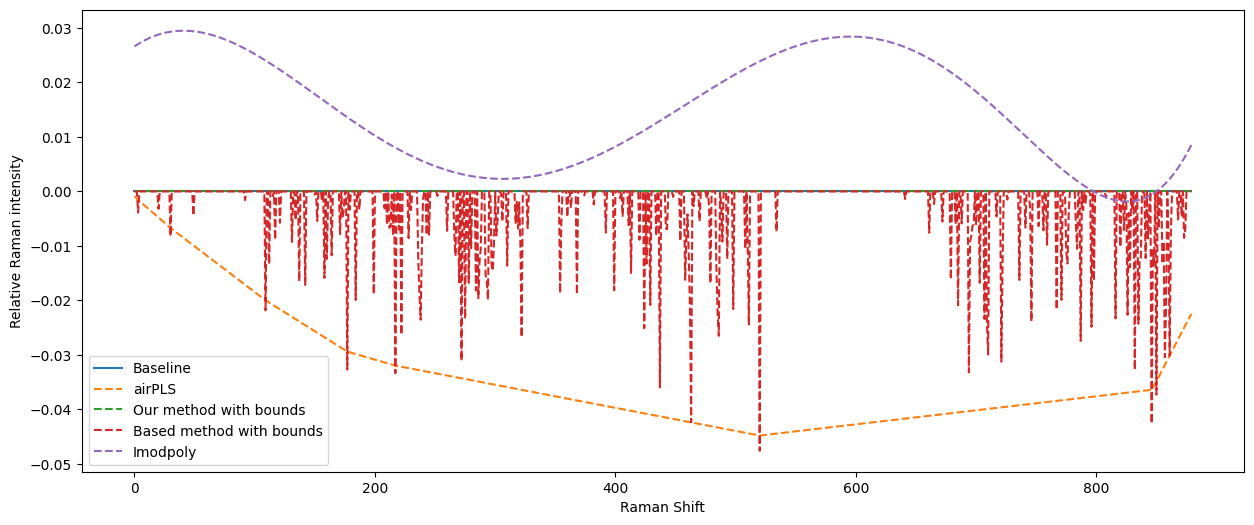

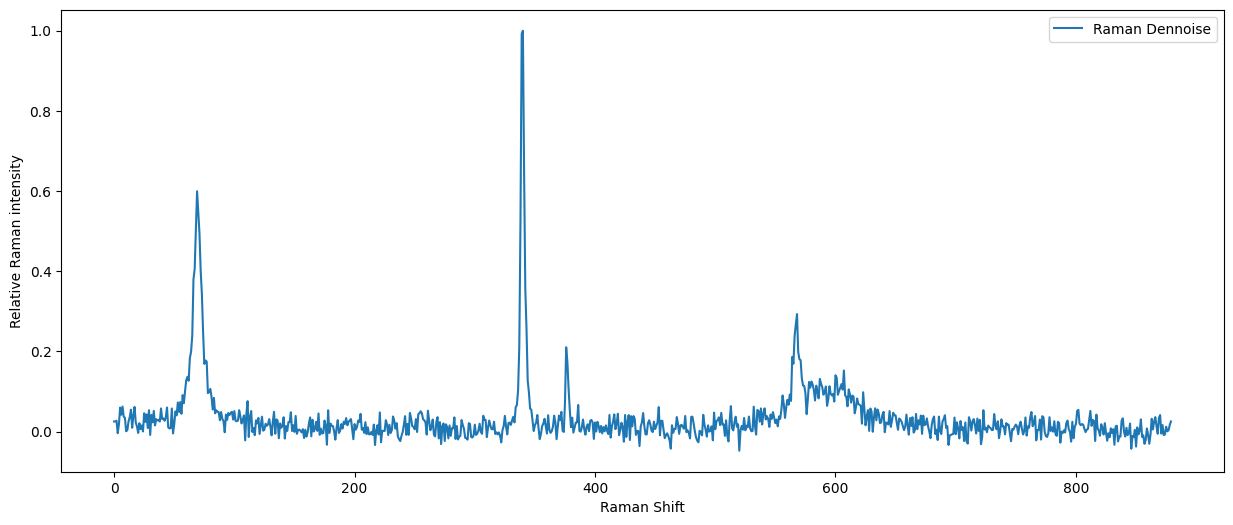

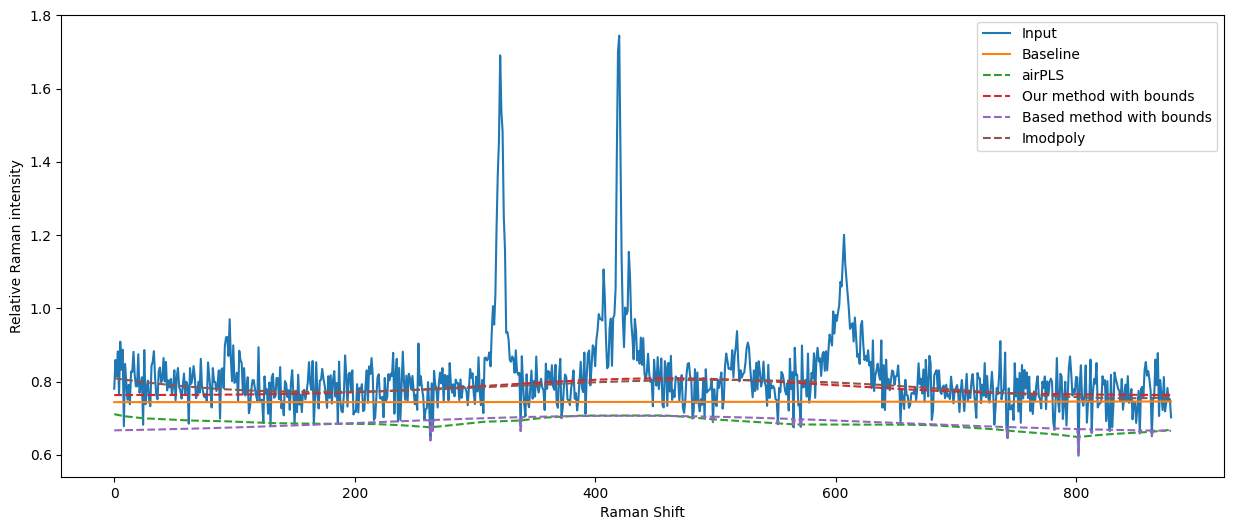

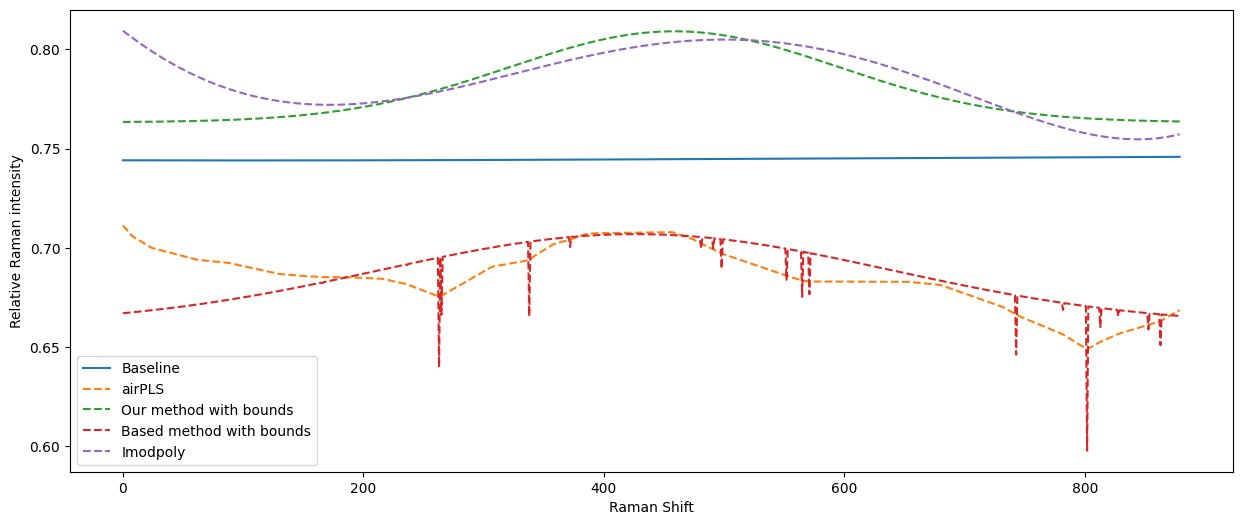

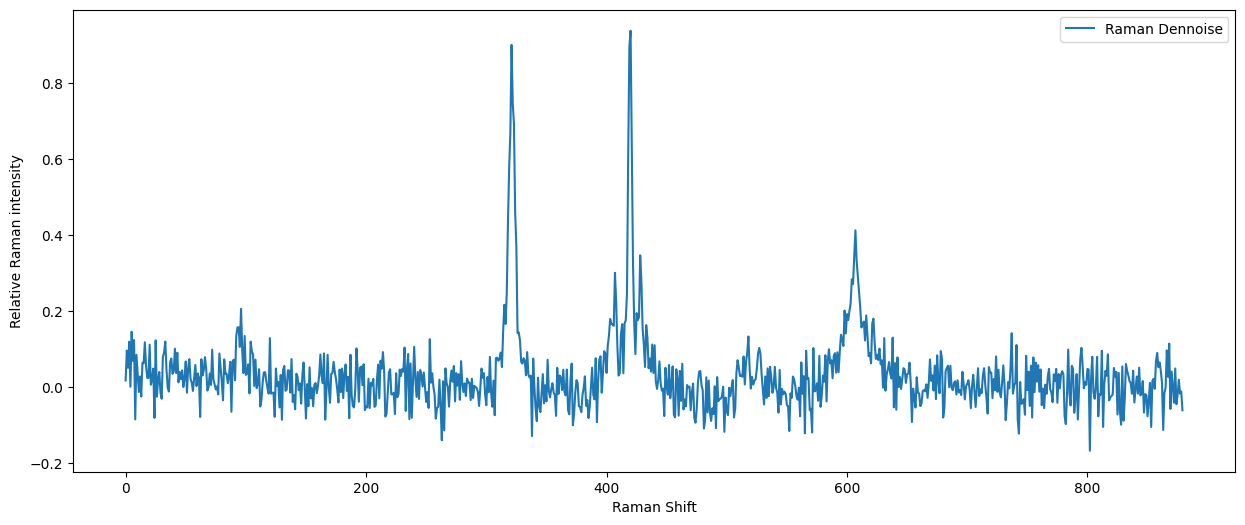

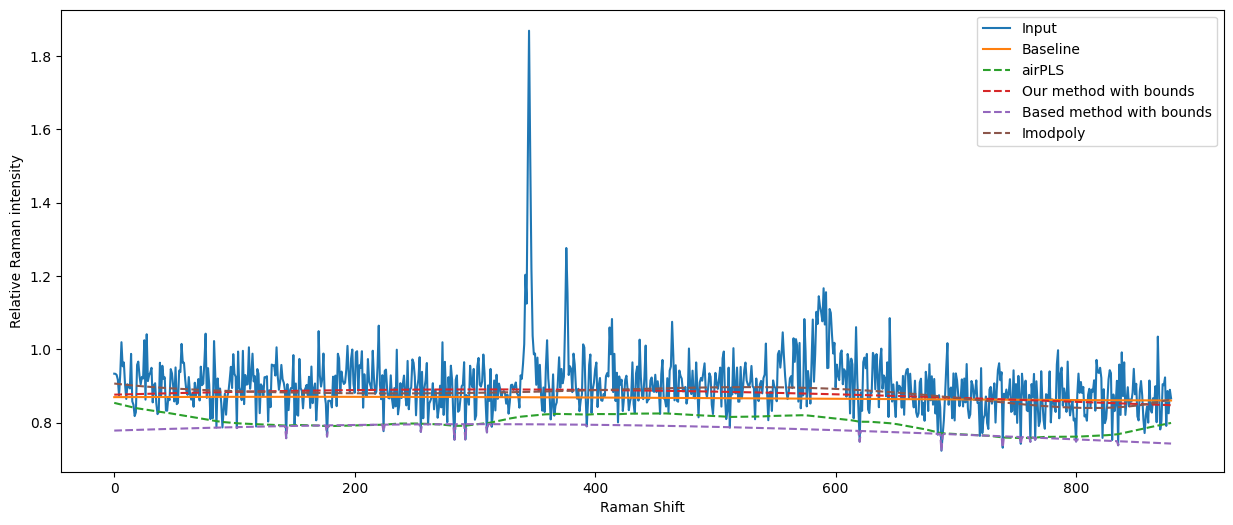

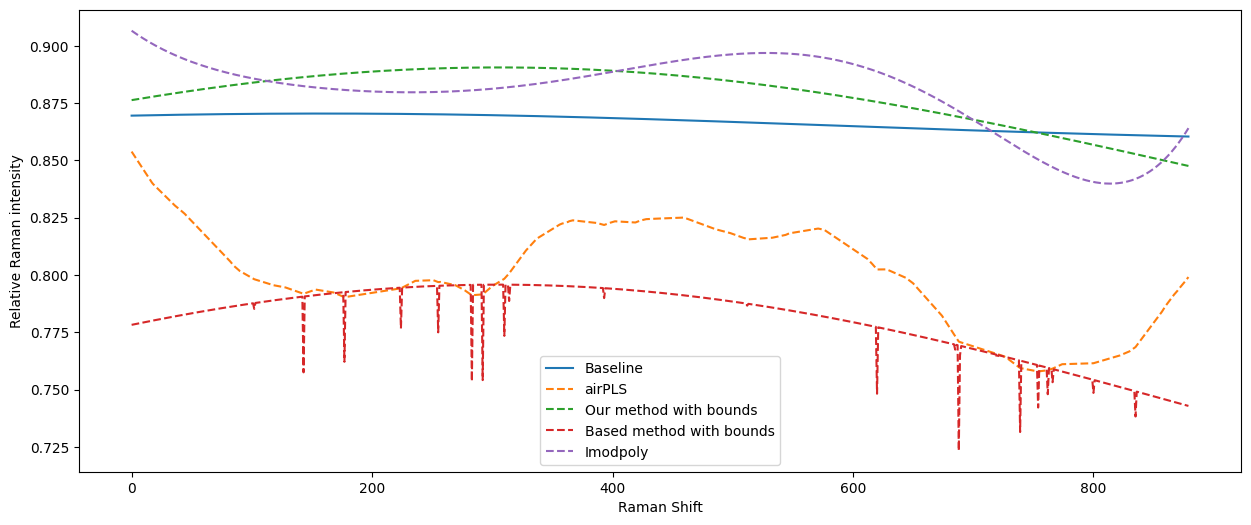

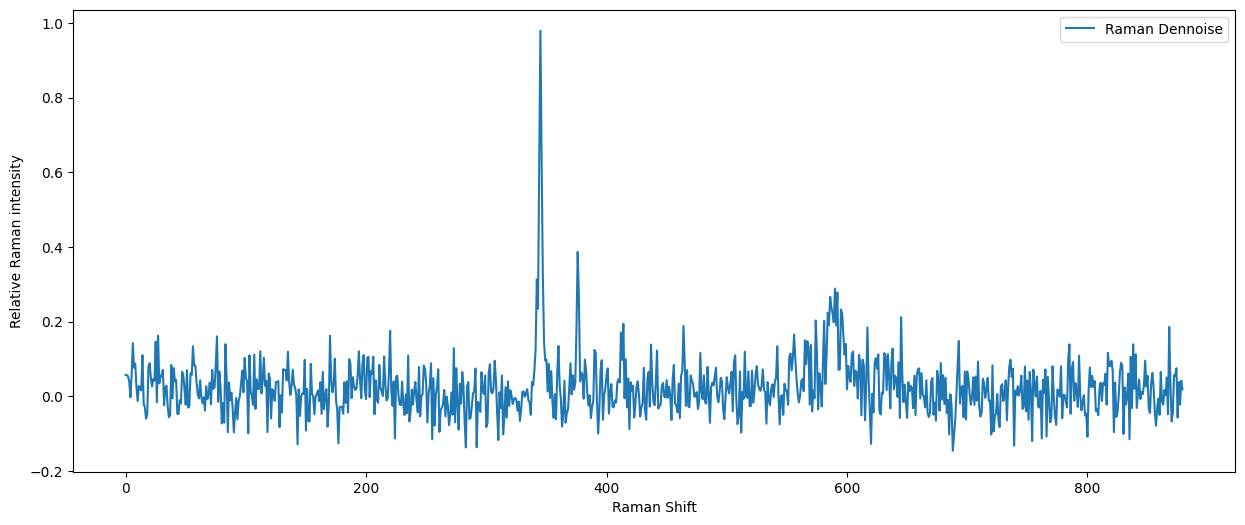

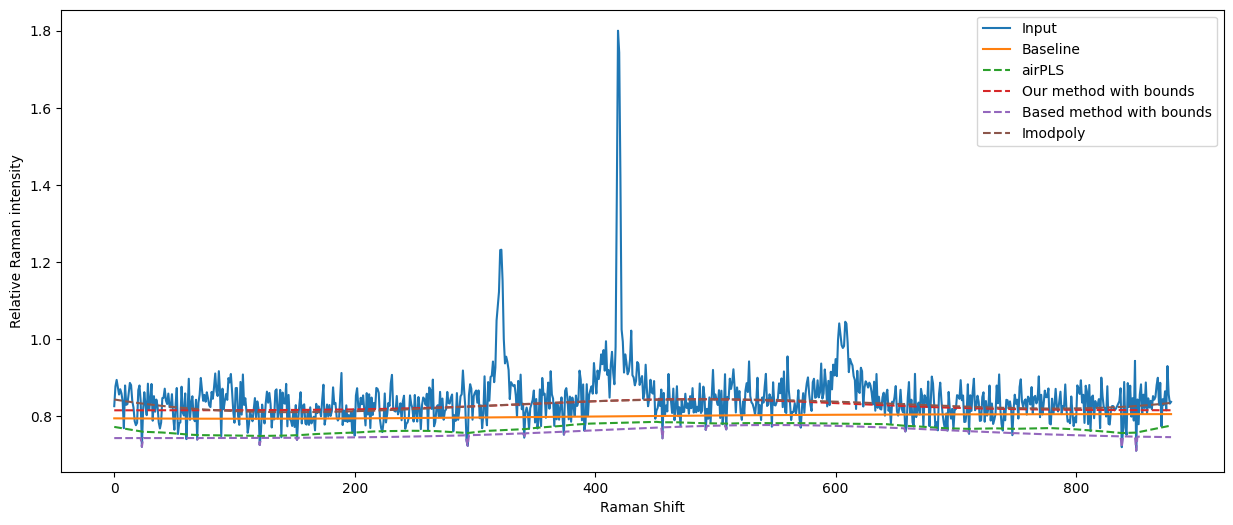

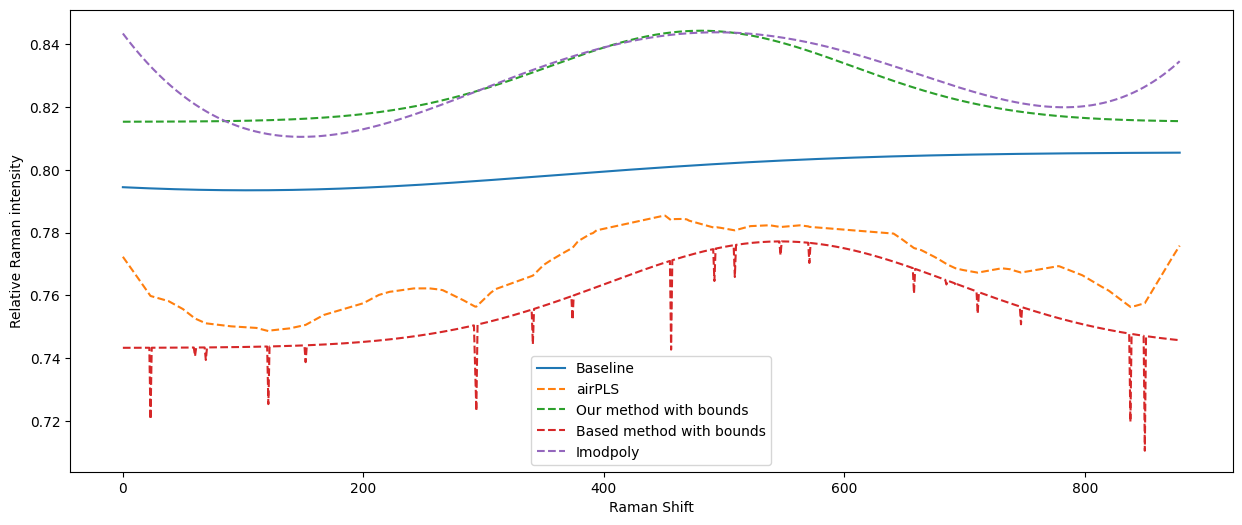

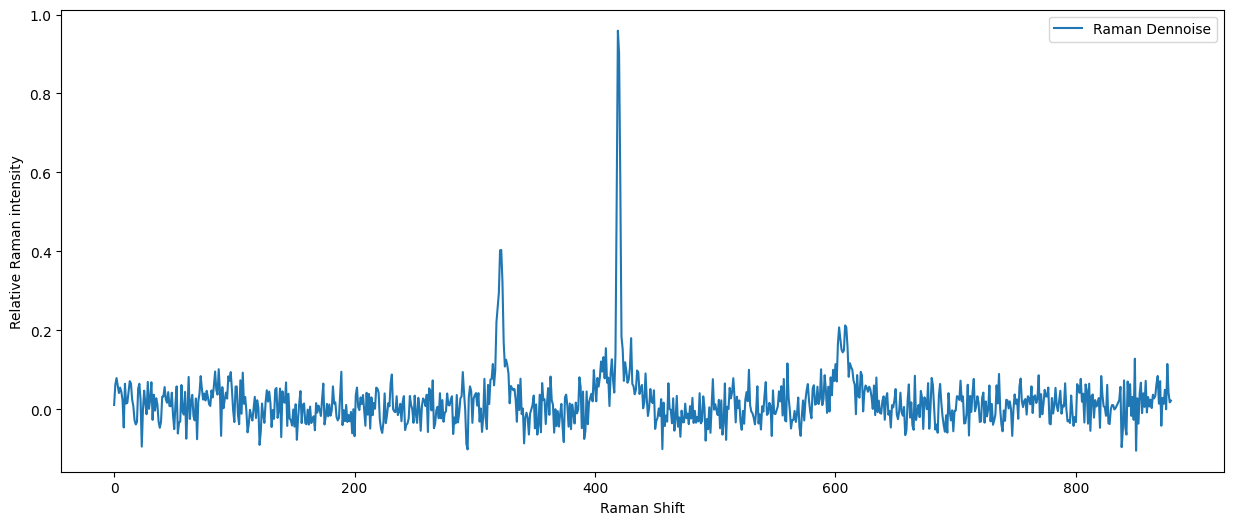

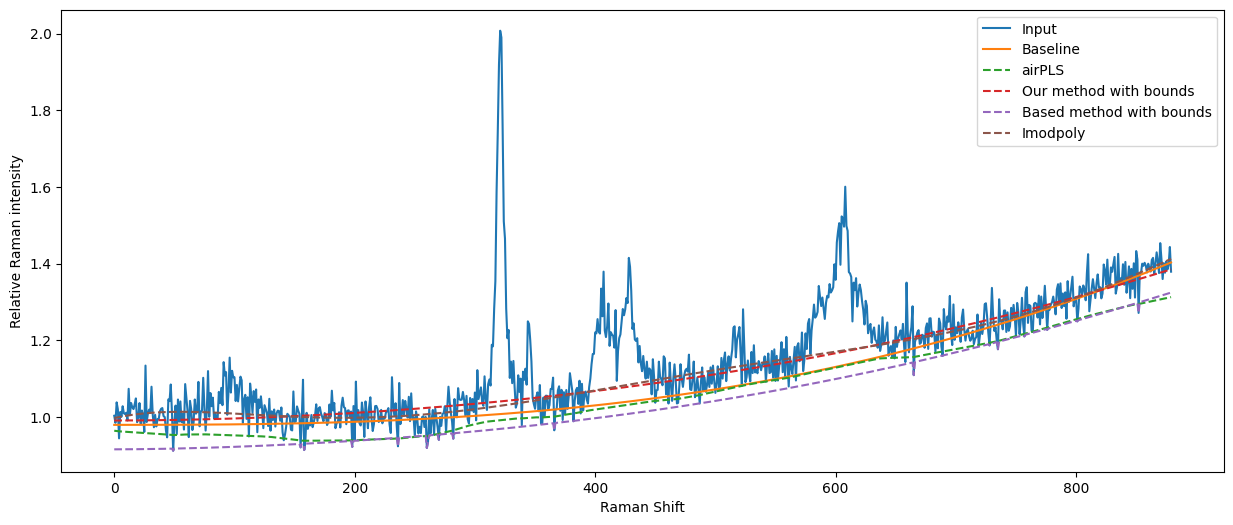

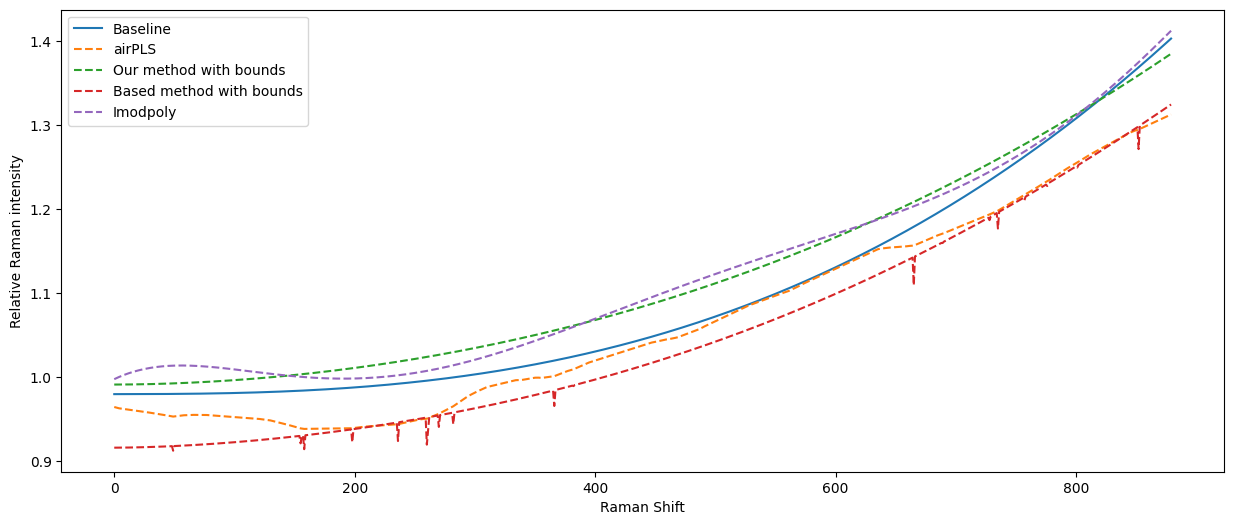

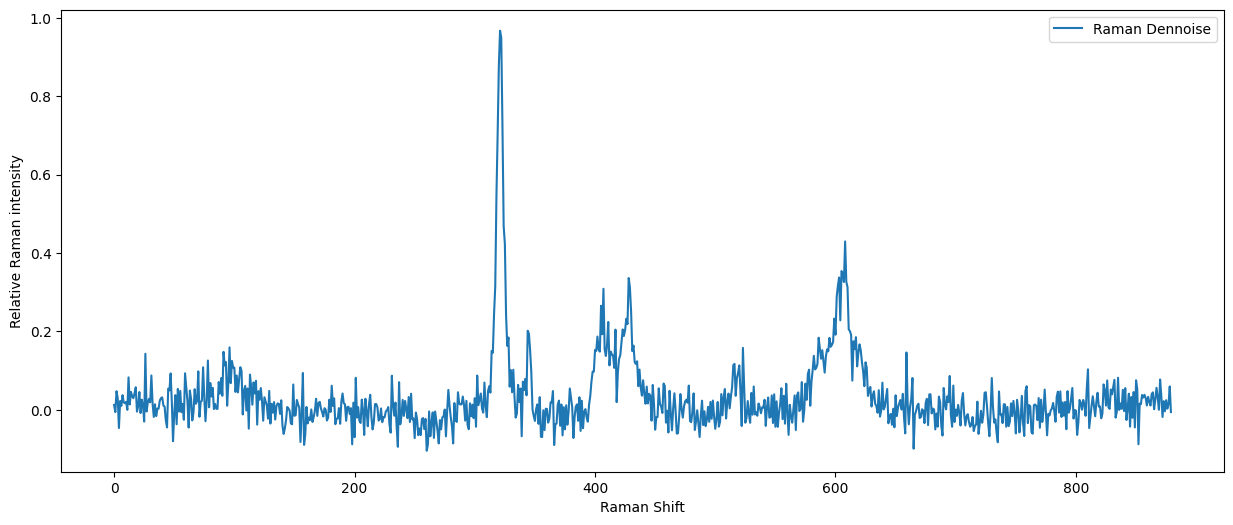

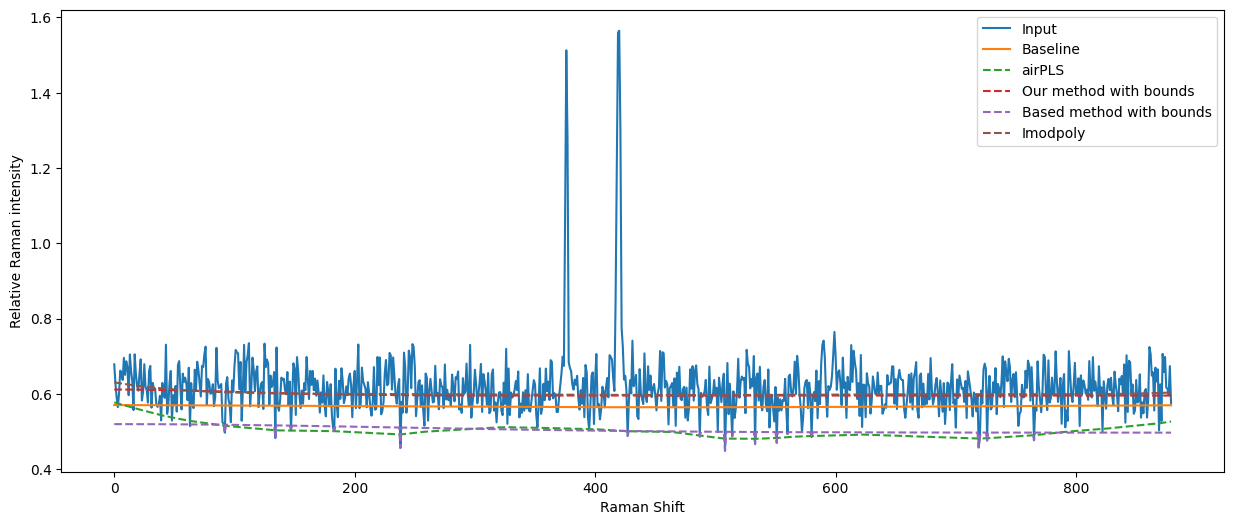

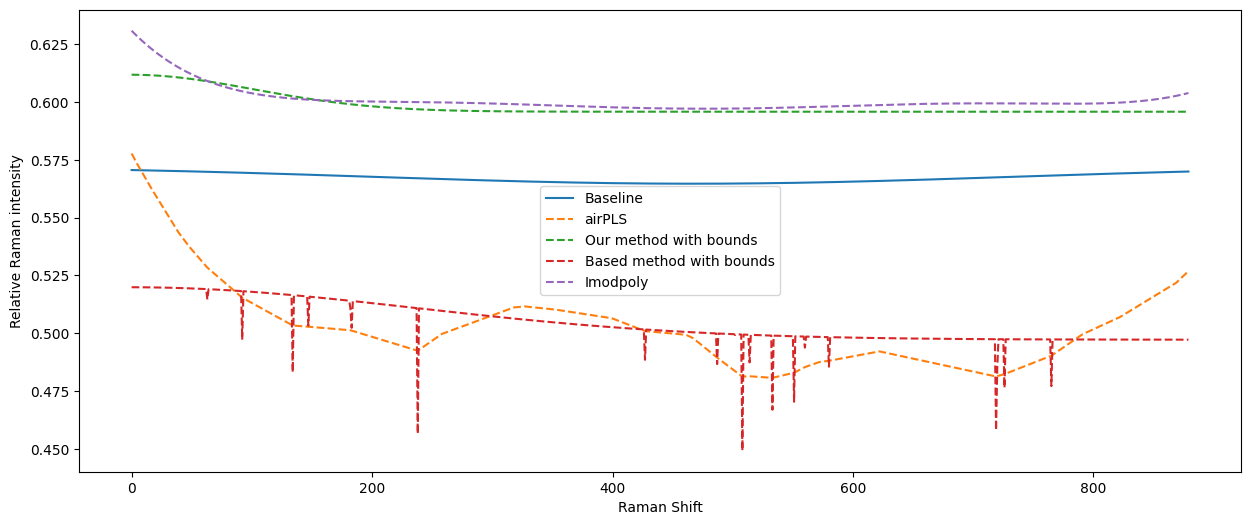

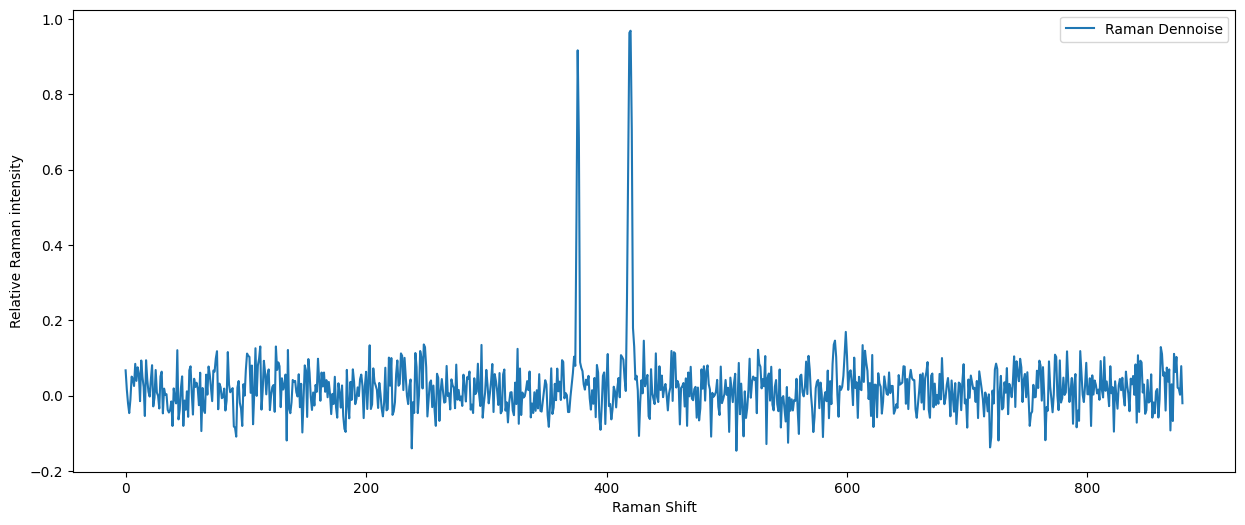

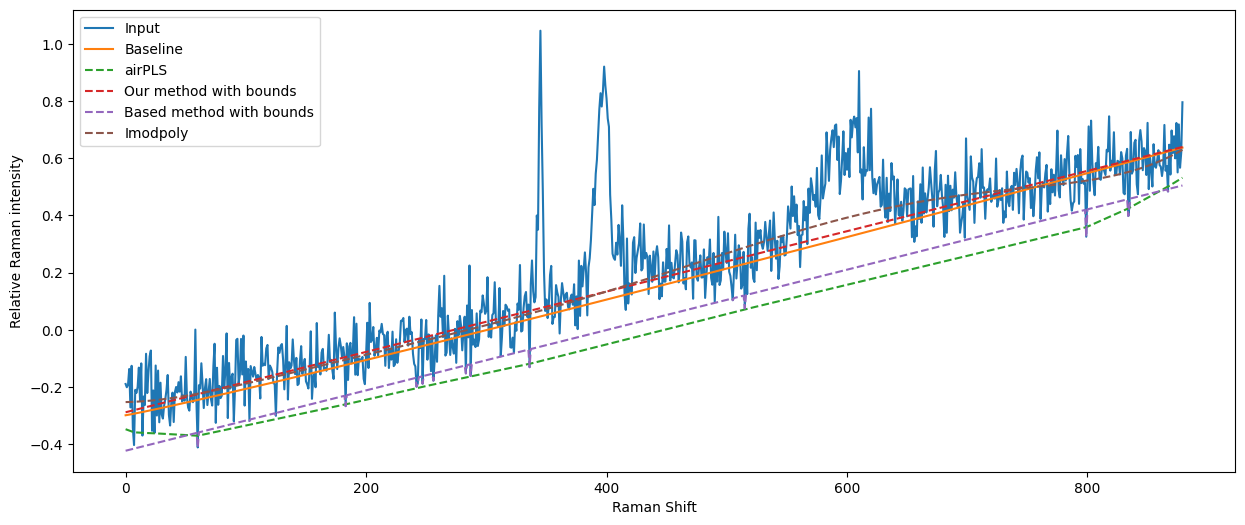

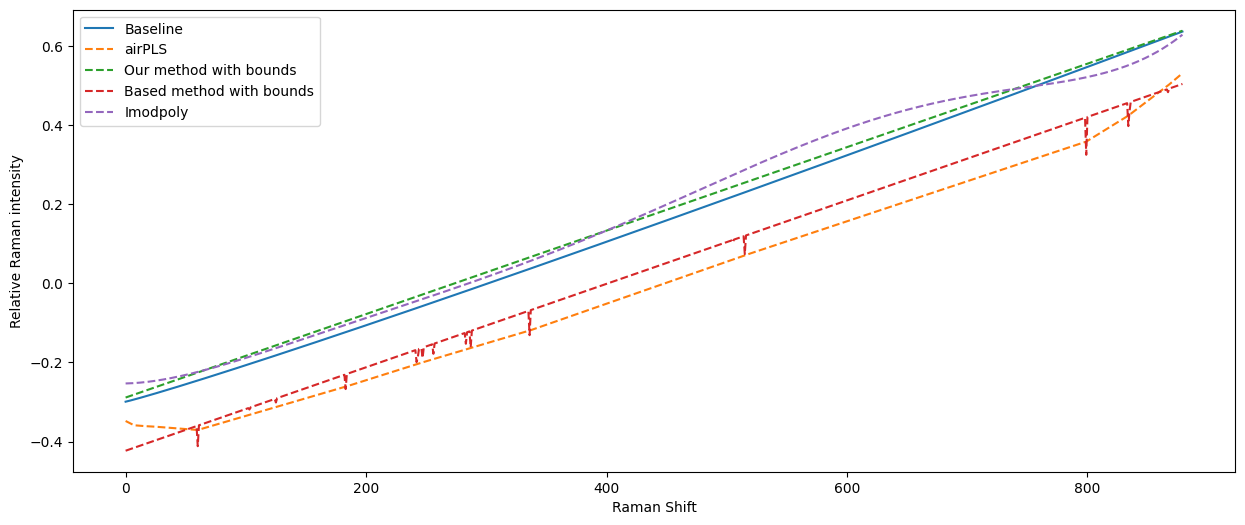

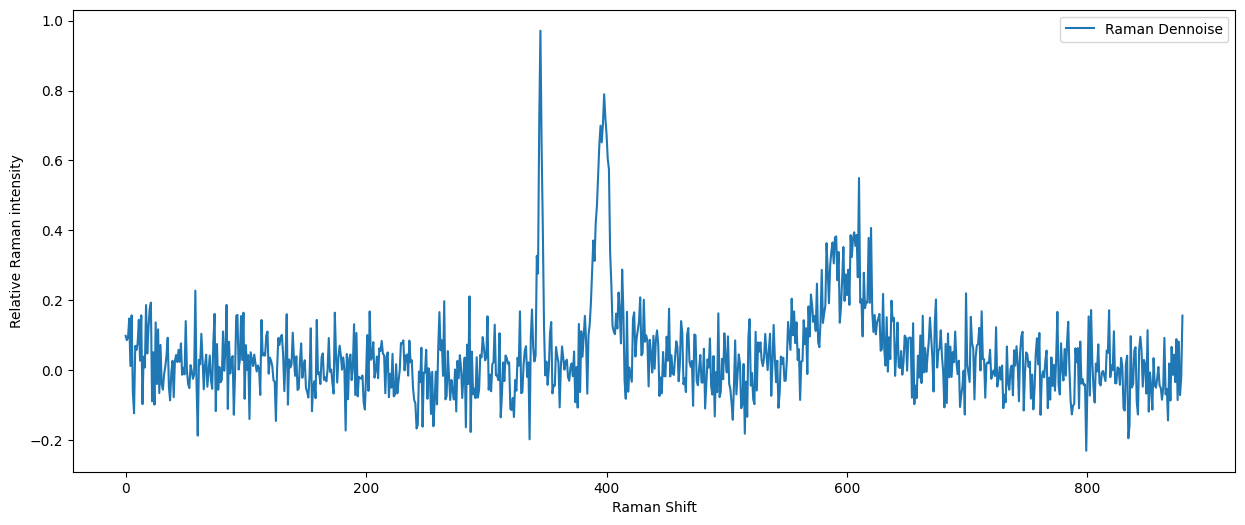

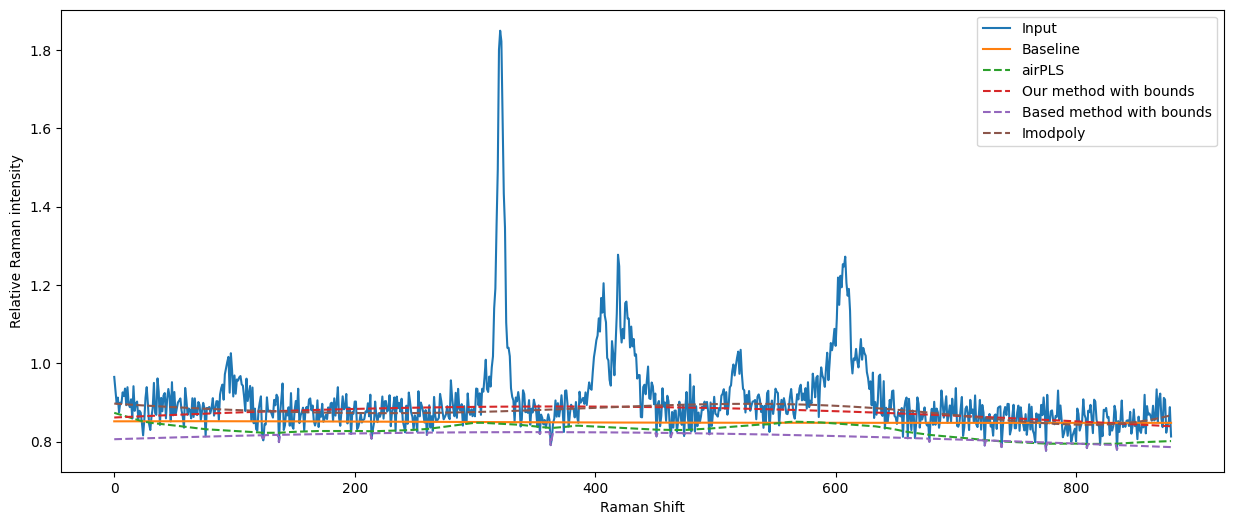

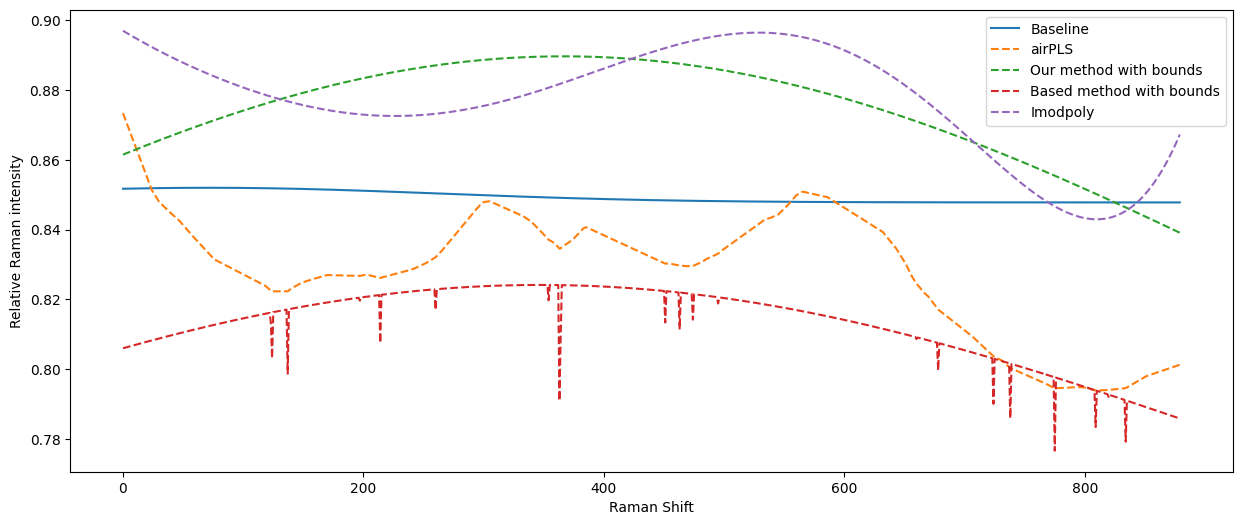

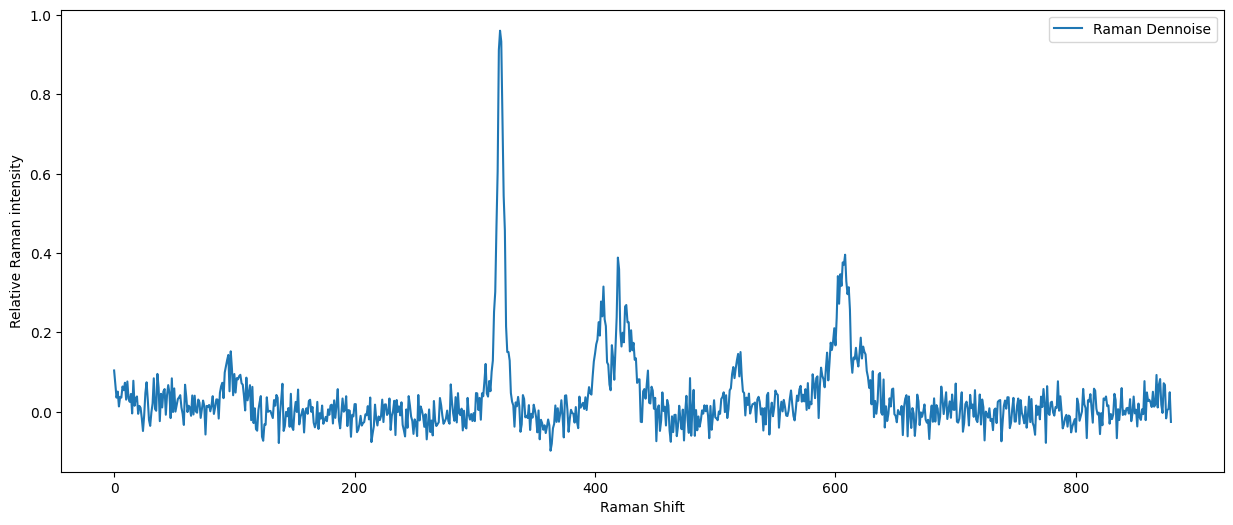

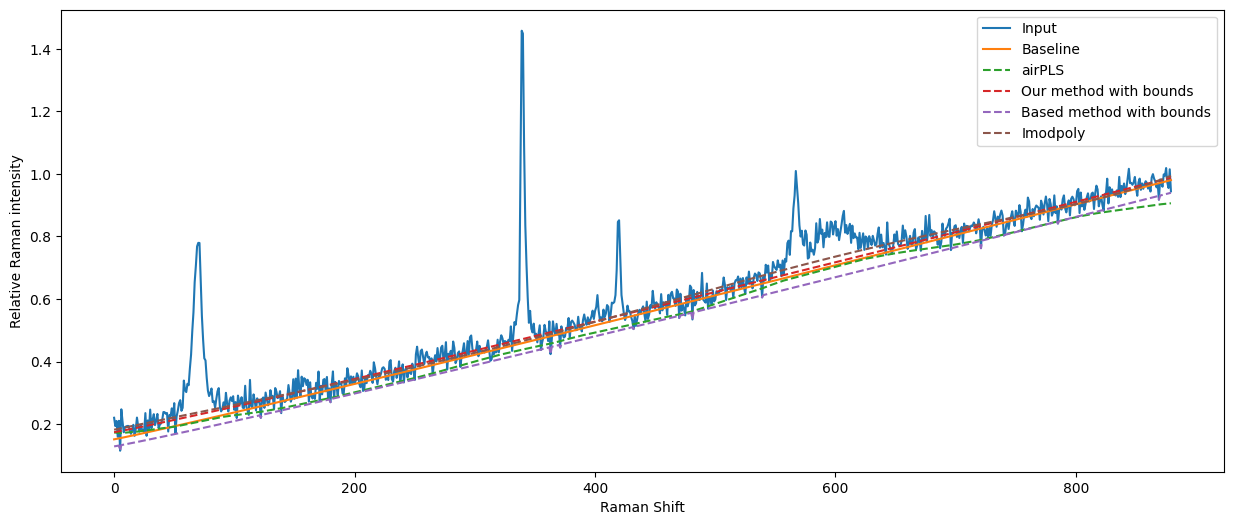

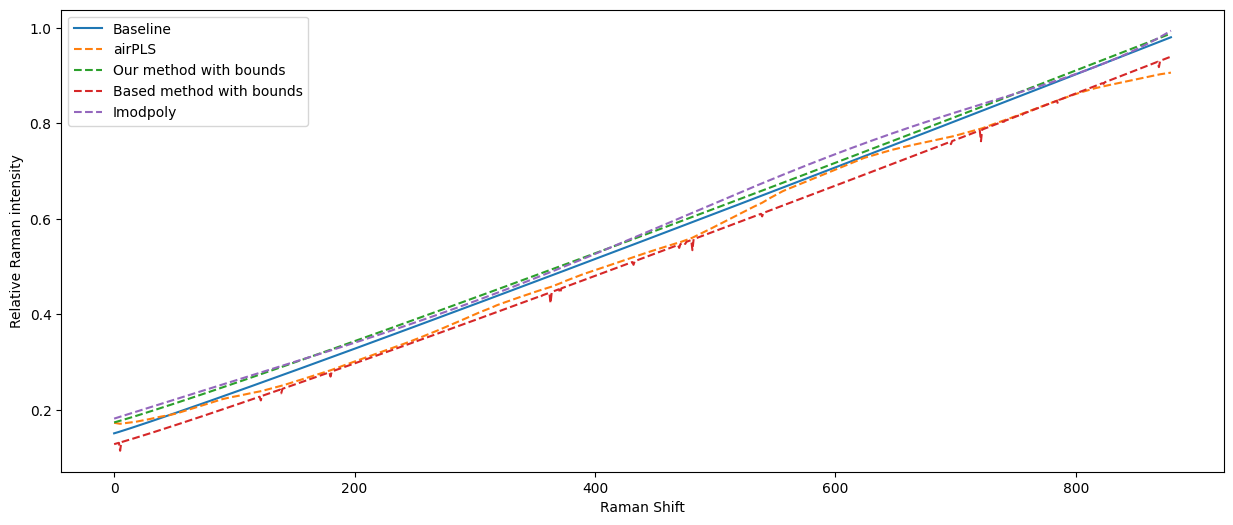

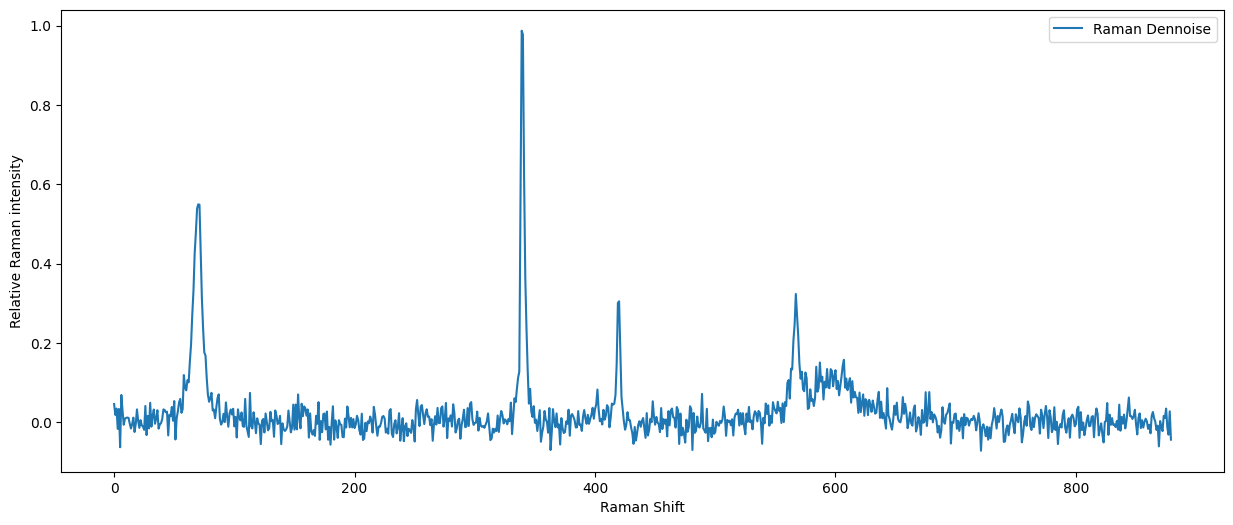

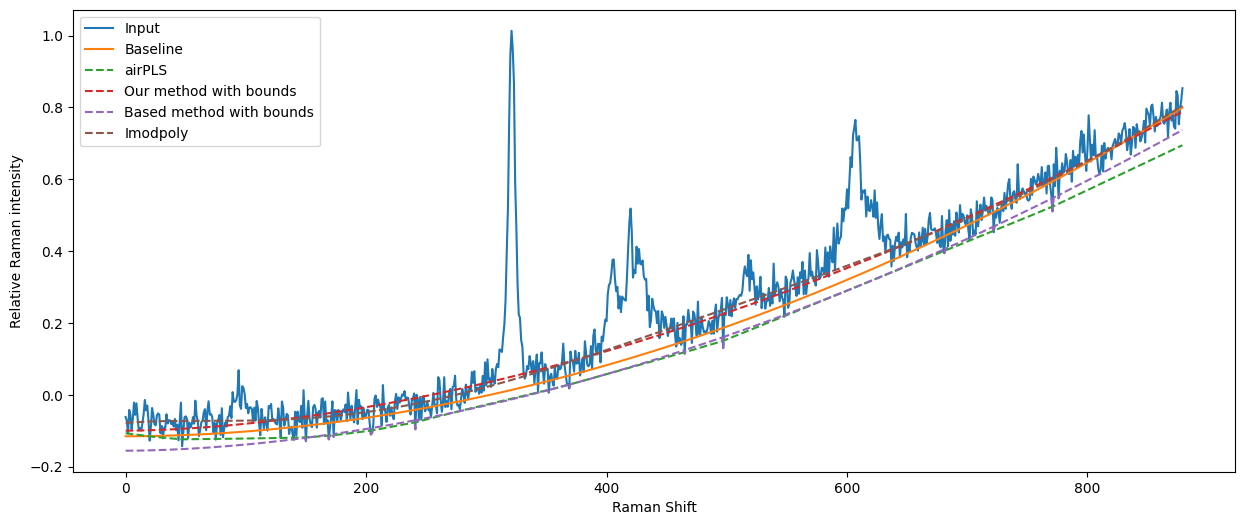

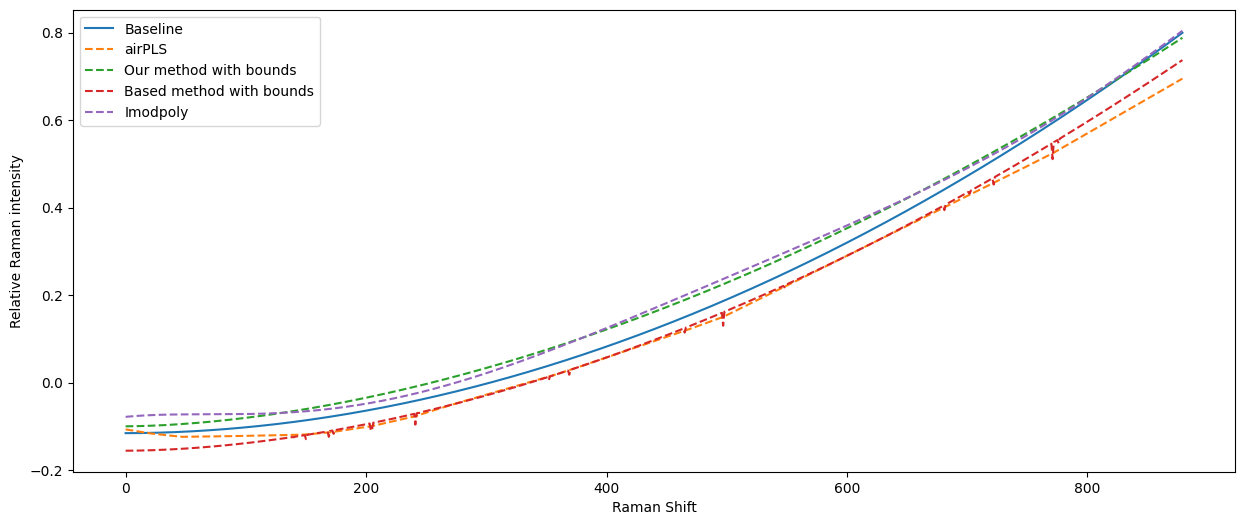

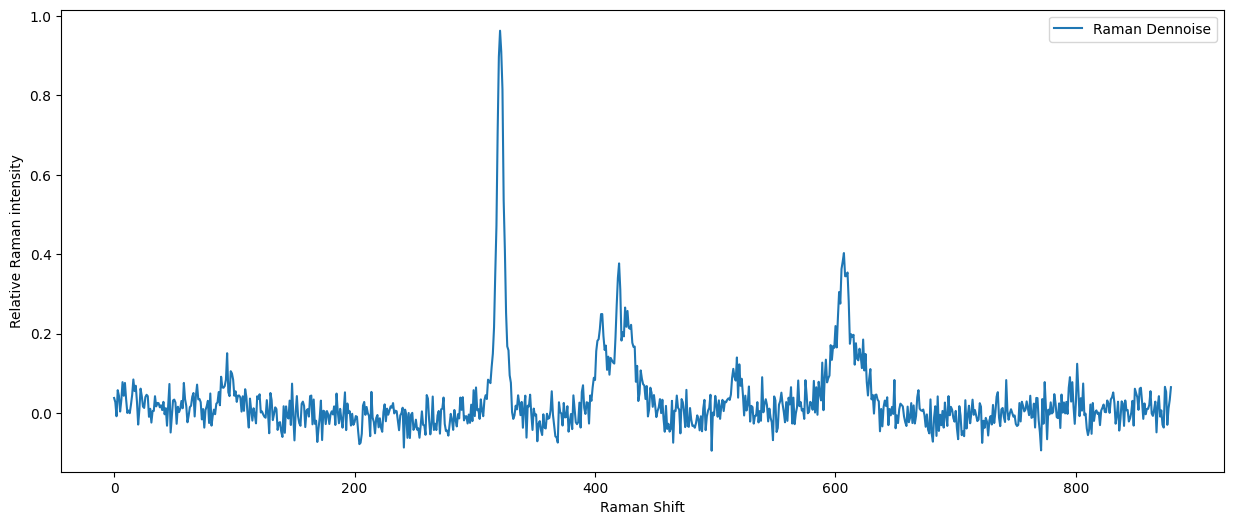

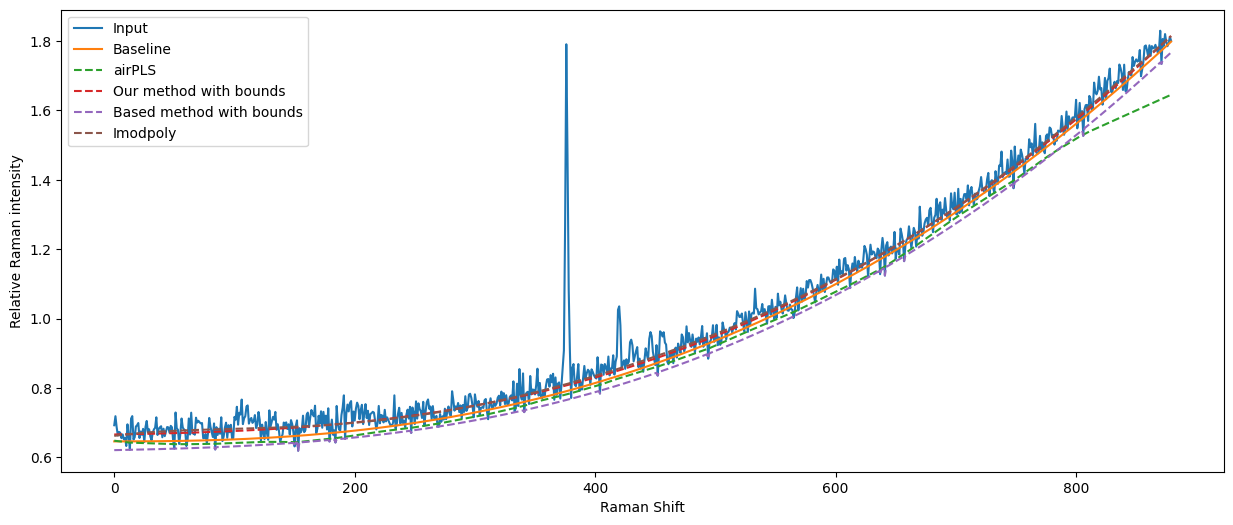

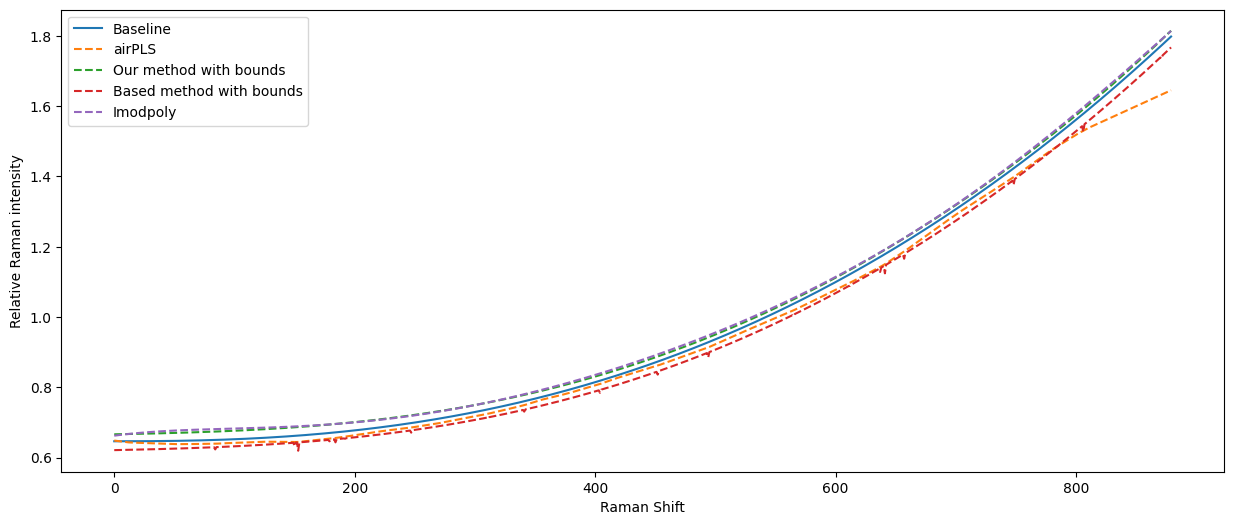

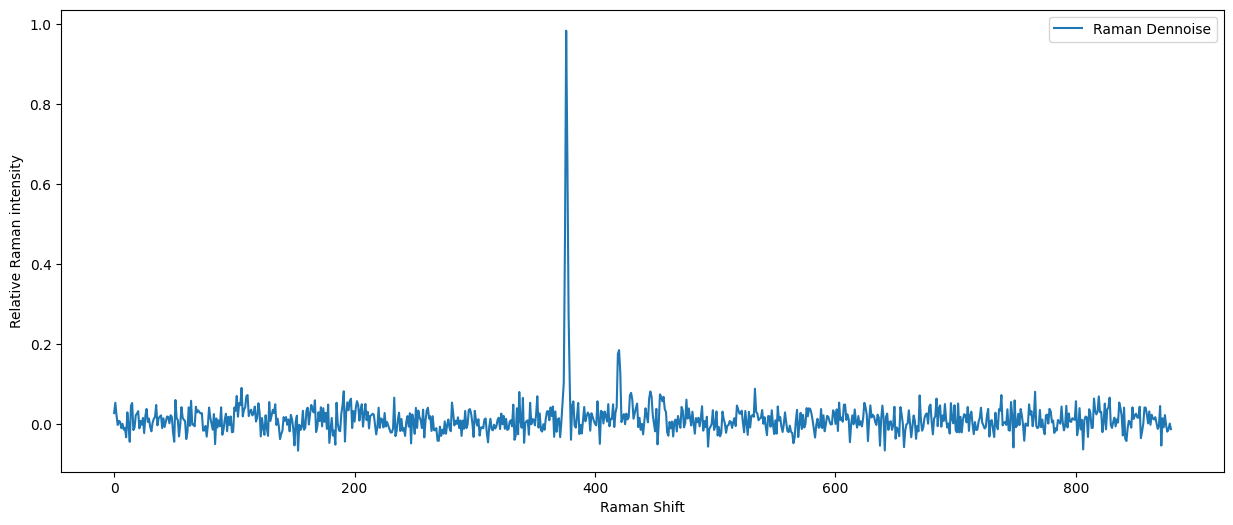

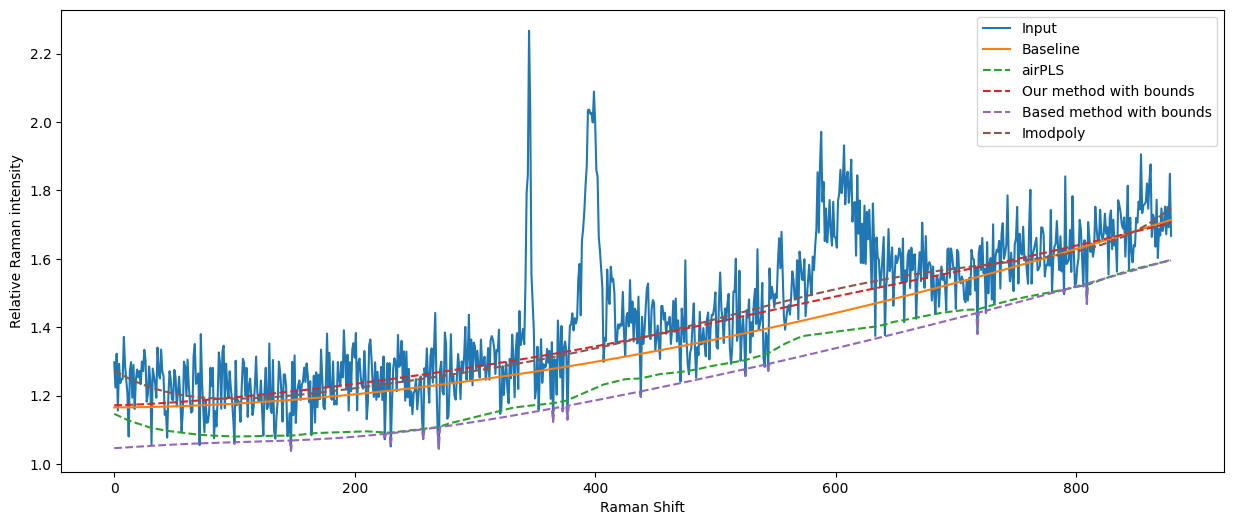

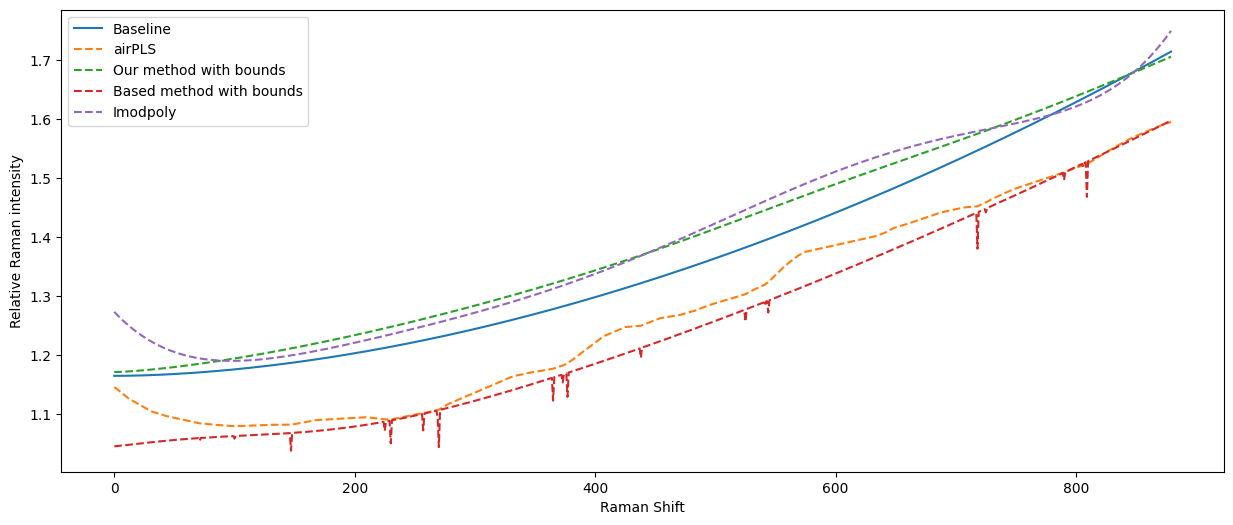

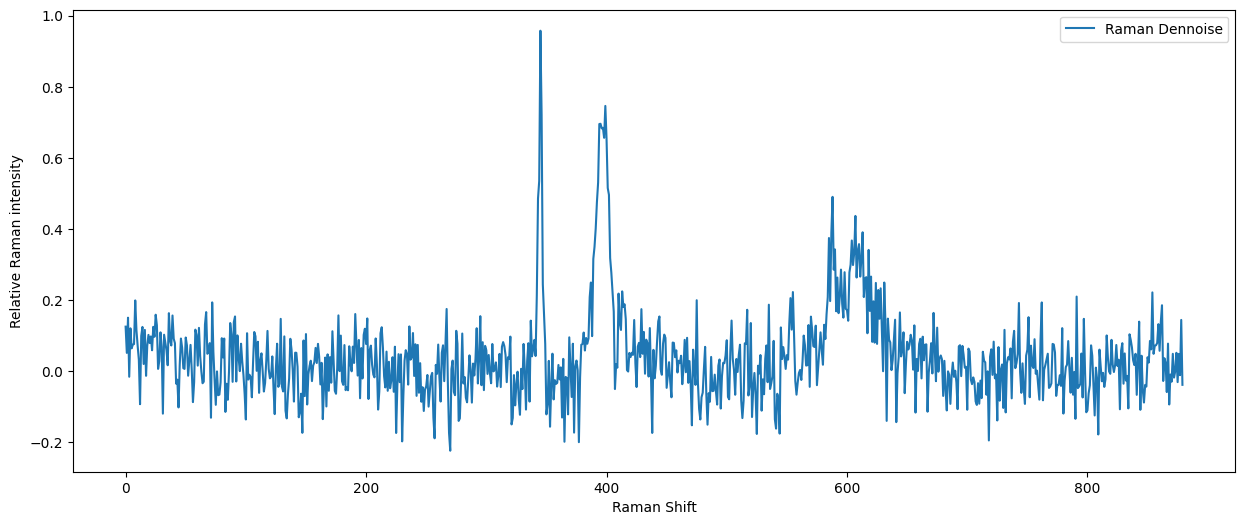

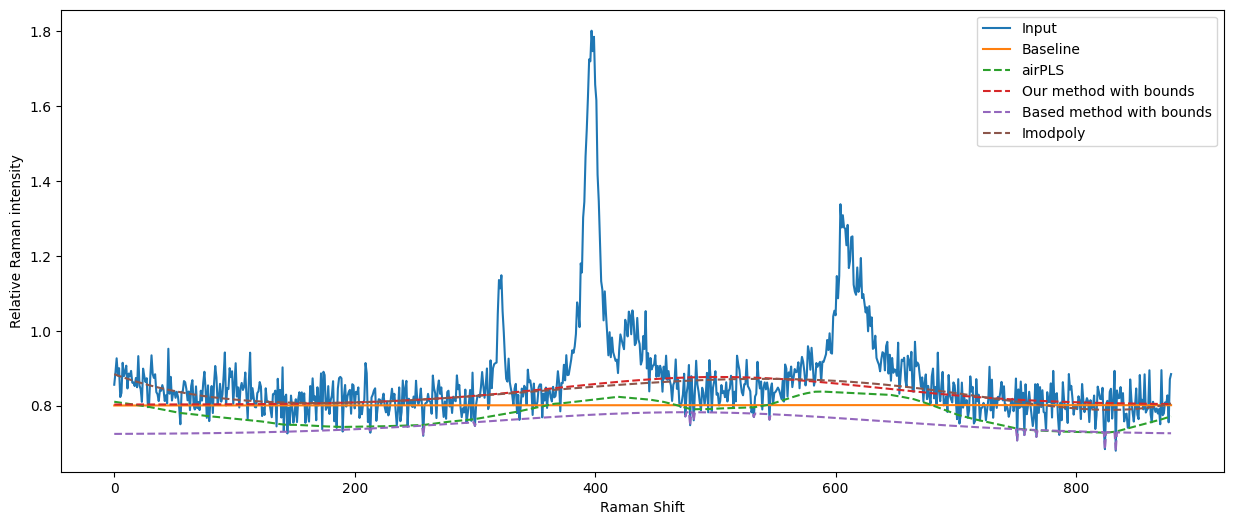

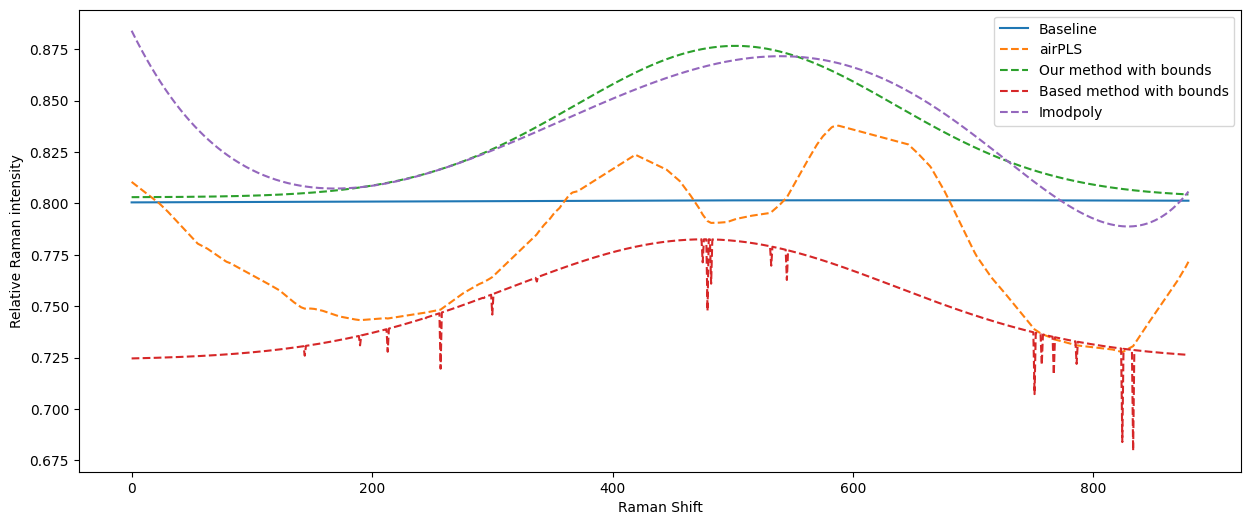

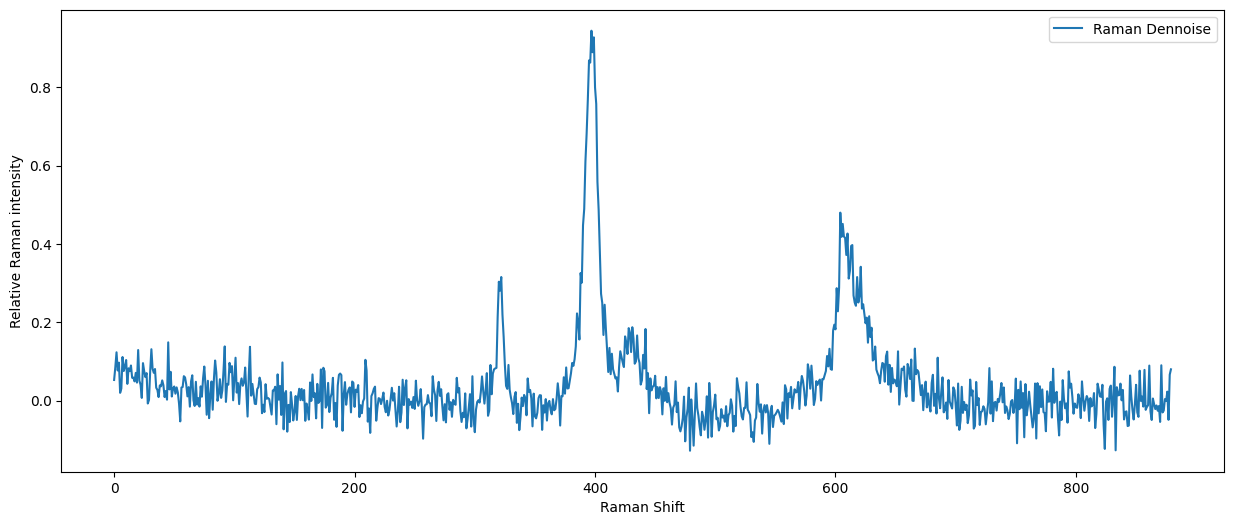

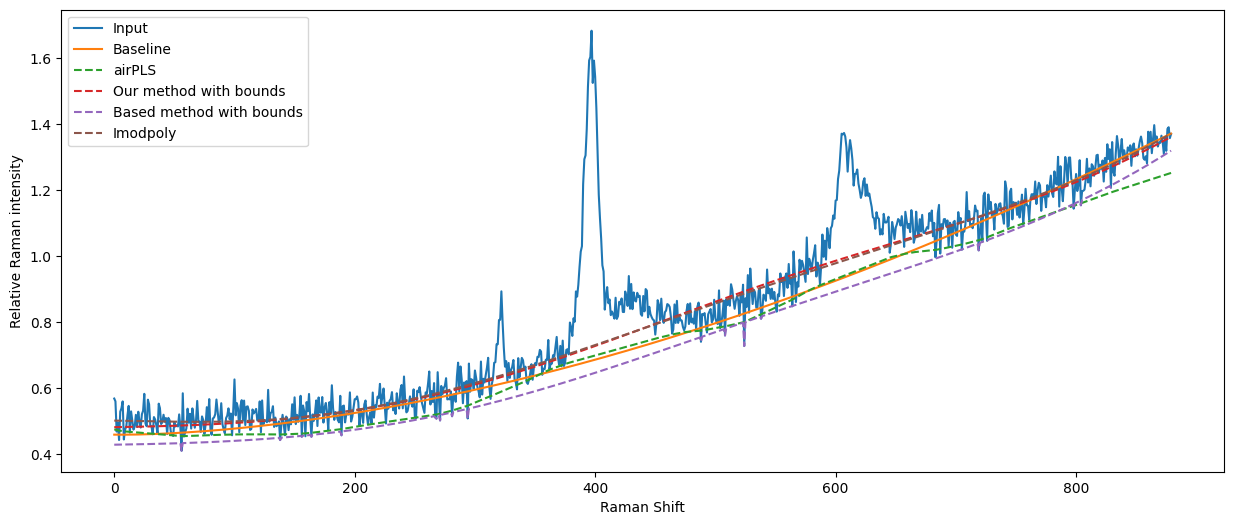

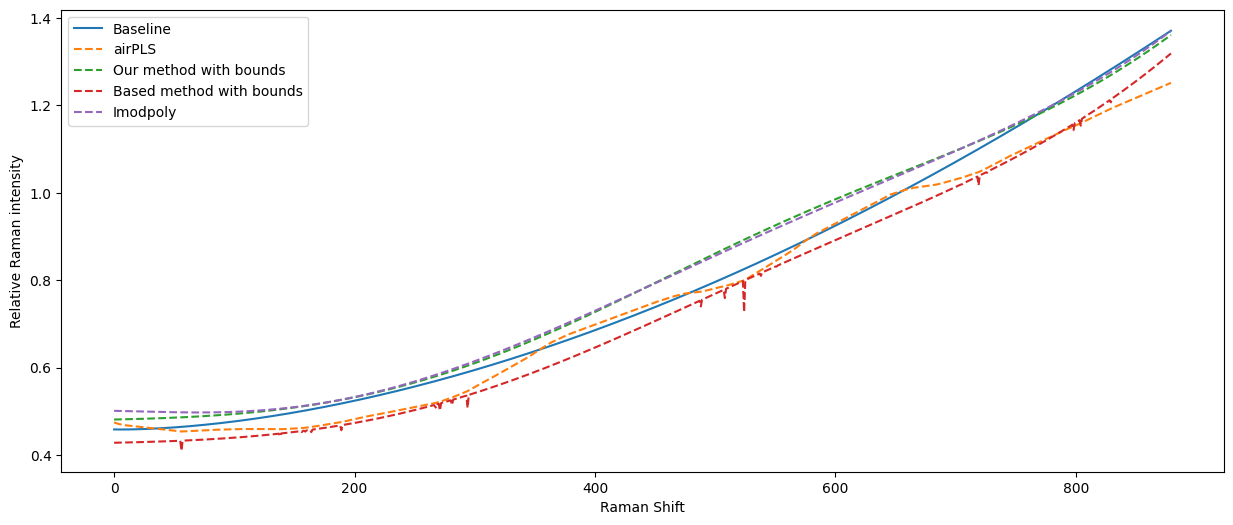

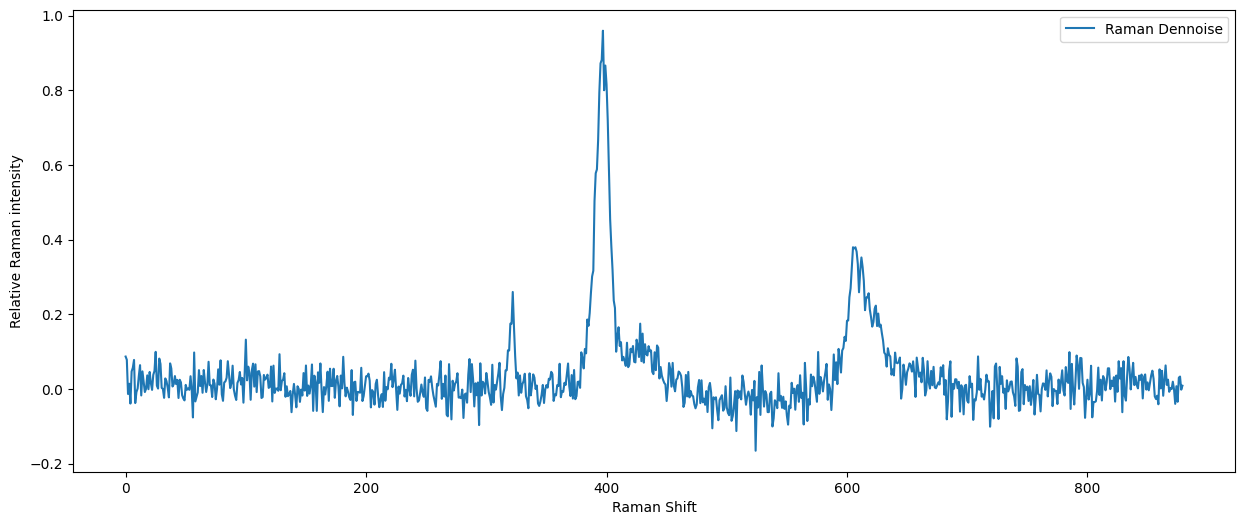

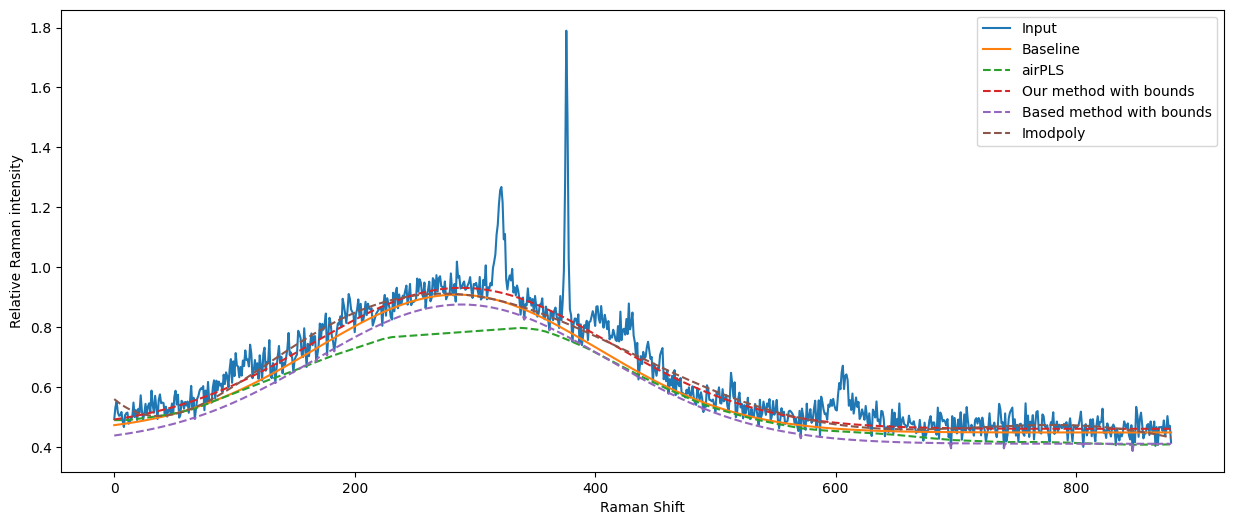

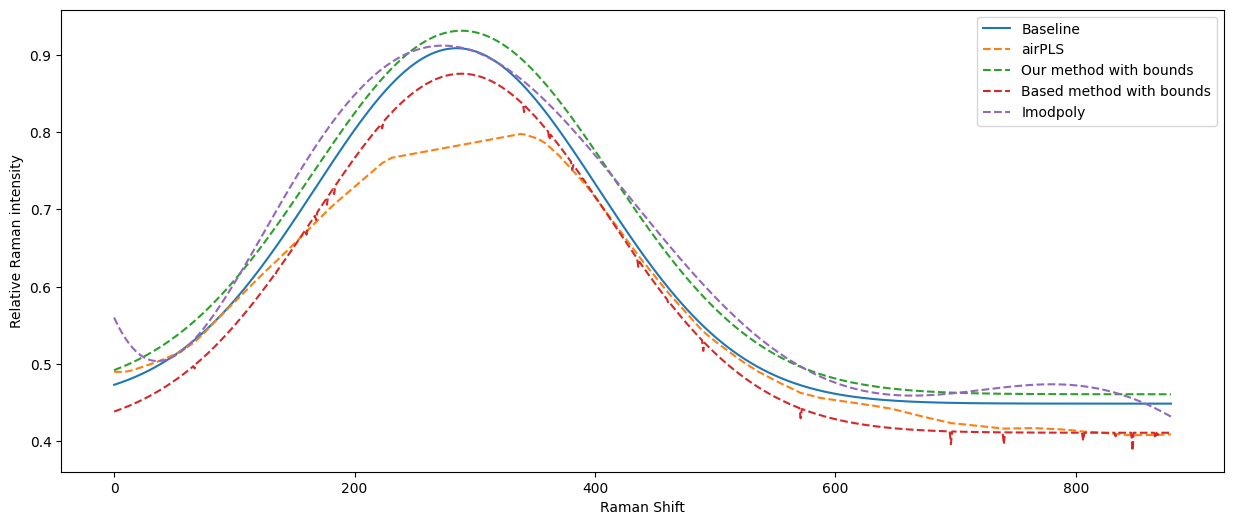

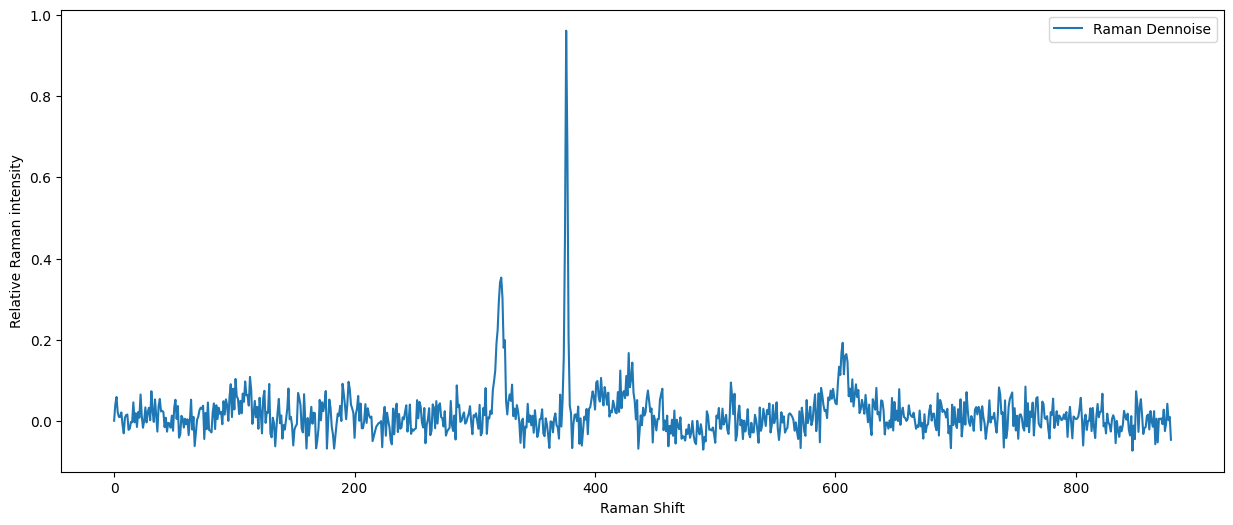

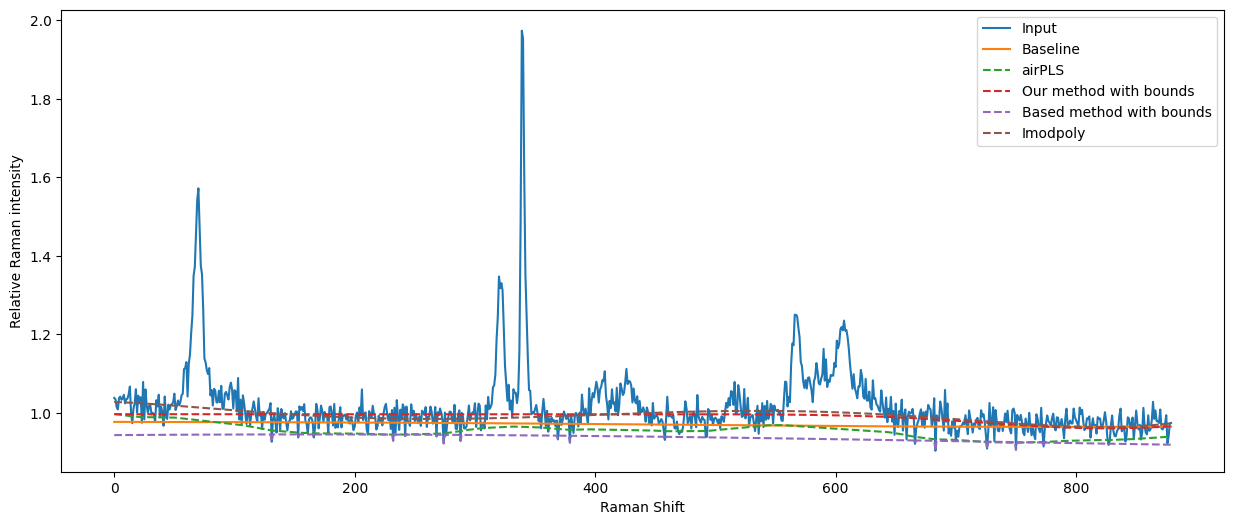

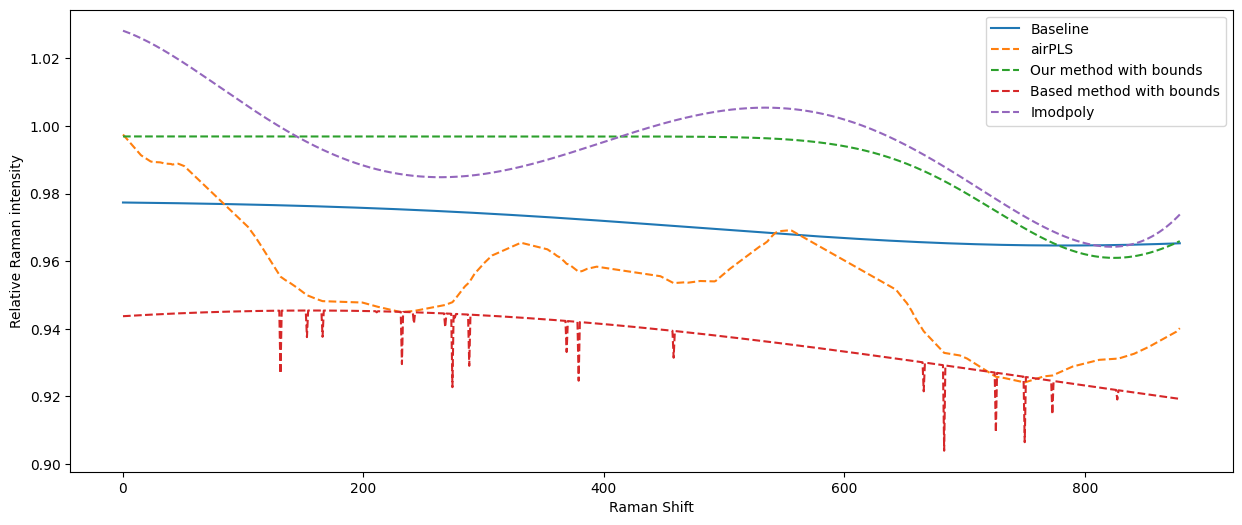

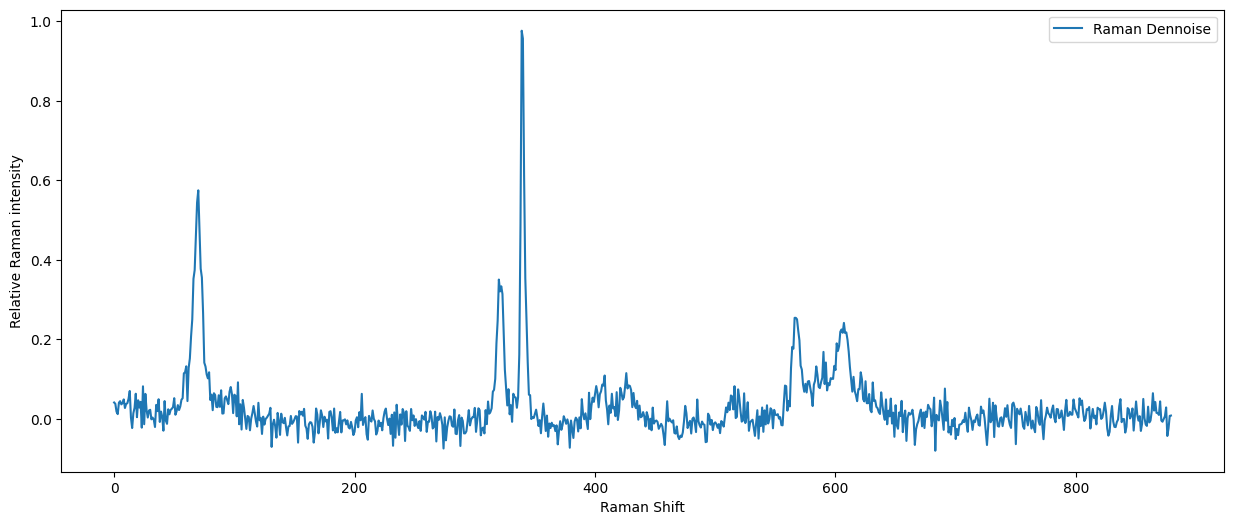

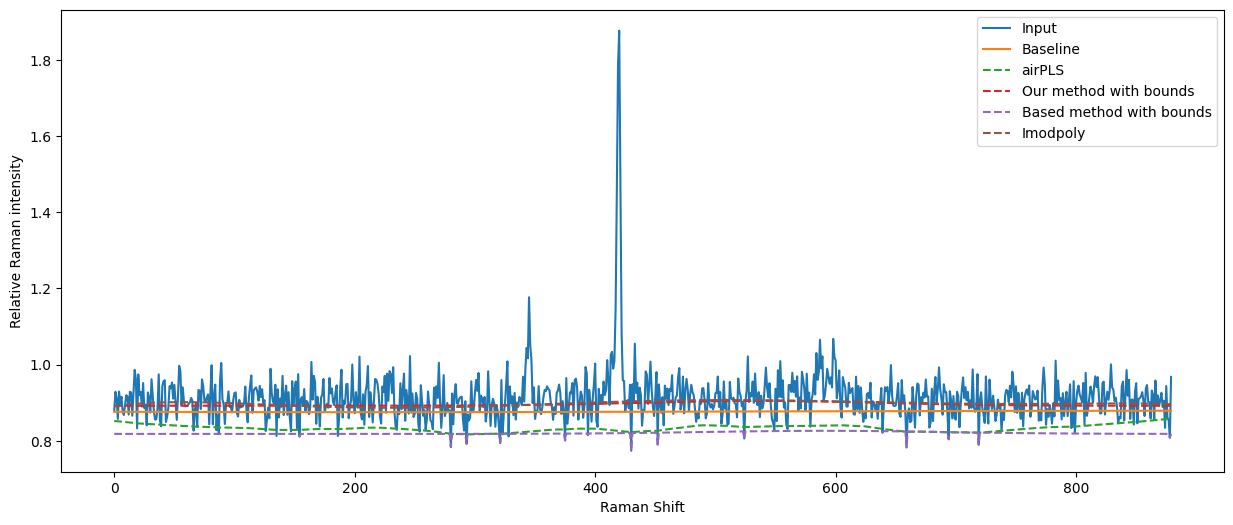

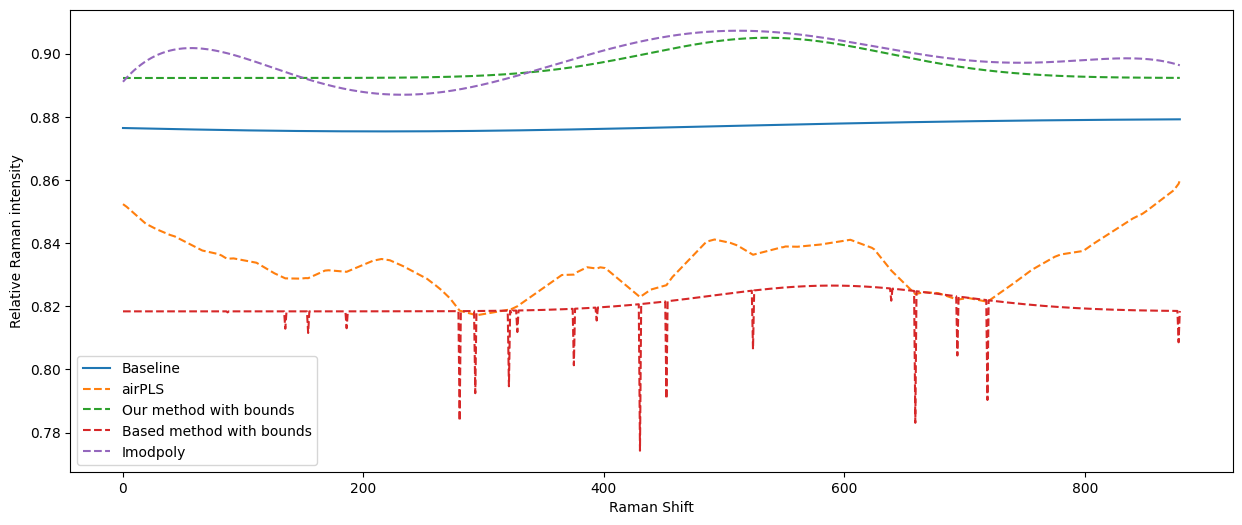

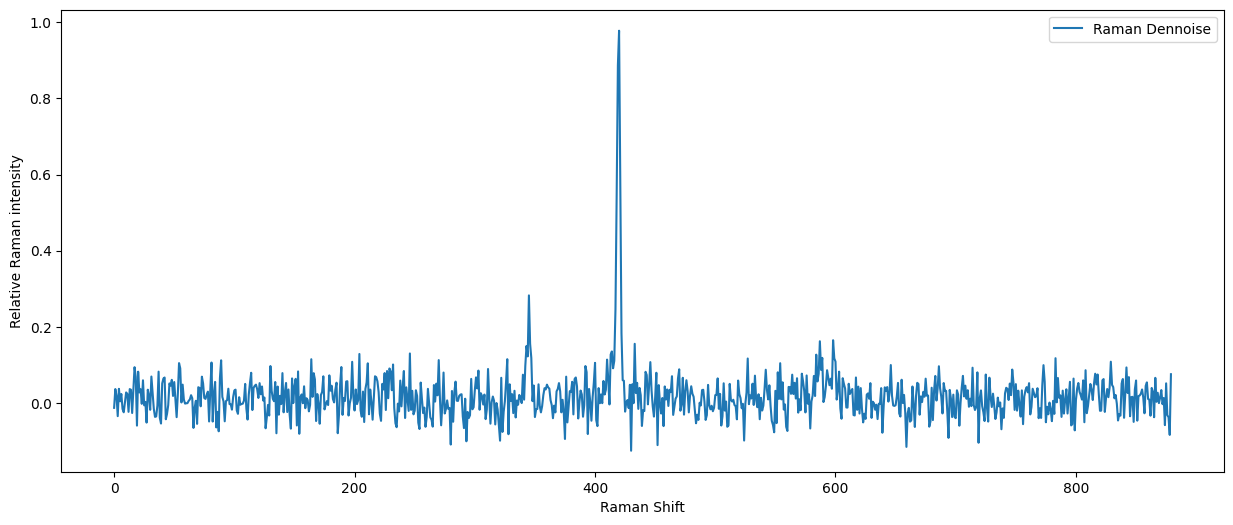

In [16]:
import matplotlib.pyplot as plt
from BaselineRemoval import BaselineRemoval
import pybaselines
import pandas as pd

# Đọc dữ liệu từ tệp CSV vào DataFrame, bỏ qua dòng đầu tiên
df = pd.read_csv("./data/Baseline_test_01104.csv", skiprows=1, header=None)

# Chuyển đổi DataFrame thành mảng numpy
data_array = df.values

print("Đọc dữ liệu")

# Tách nhãn từ dữ liệu
y_train = data_array[:, :2]
y_train = tf.cast(y_train, tf.float32)

# Tách dữ liệu vào x_train
x_train = data_array[:, 2:882]
baseline_train = data_array[:, 882:]

for i in range(0,20):
    plt.figure(figsize=(15,6))

    sample_index = i
    sample_data = x_train[sample_index]
    xx=tf.expand_dims(sample_data, axis=0)
    plt.plot(sample_data, label="Input")
    plt.plot(baseline_train[sample_index], label="Baseline")
    output=model(xx)
    B =iterative_fitting_with_bounds(sample_data,50)
    B_1 =iterative_fitting_with_bounds_no(sample_data,50)
    
    base_lines2 , _ = pybaselines.polynomial.imodpoly(data=xx[0], poly_order=6, max_iter=500)
    sample_data_1 = sample_data
    B3=airPLS(sample_data)
    plt.plot(B3,"--",label="airPLS")
    plt.plot(B, "--", label="Our method with bounds")
    plt.plot(B_1, "--", label="Based method with bounds")
    plt.plot(base_lines2, "--", label="Imodpoly")
    plt.xlabel("Raman Shift")
    plt.ylabel("Relative Raman intensity")
    plt.legend()
    
    plt.figure(figsize=(15,6))
    plt.plot(baseline_train[sample_index], label="Baseline")
    plt.plot(B3,"--",label="airPLS")
    plt.plot(B, "--", label="Our method with bounds")
    plt.plot(B_1, "--", label="Based method with bounds")
    
    plt.plot(base_lines2, "--", label="Imodpoly")
    plt.xlabel("Raman Shift")
    plt.ylabel("Relative Raman intensity")
    plt.legend()

    plt.figure(figsize=(15,6))
    plt.plot(sample_data - B, label="Raman Dennoise")
    plt.xlabel("Raman Shift")
    plt.ylabel("Relative Raman intensity")
    plt.legend()

In [17]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import pybaselines
import time  # Thêm import cho module time

print("start")

# Định nghĩa hàm tính RMSE
def calculate_rmse(y_true, y_pred):
    """
    Function to calculate Root Mean Squared Error (RMSE)

    Parameters:
    - y_true: numpy array, true values
    - y_pred: numpy array, predicted values

    Returns:
    - rmse: float, RMSE value
    """
    # Reshape y_true_batch để có cùng kích thước với y_pred_batch
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

# Đọc dữ liệu từ tệp CSV vào DataFrame, bỏ qua dòng đầu tiên
df = pd.read_csv("./data/Baseline_test_01104.csv", skiprows=1, header=None)

# Chuyển đổi DataFrame thành mảng numpy
data_array = df.values

print("Đọc dữ liệu")

# Tách nhãn từ dữ liệu
y_train = data_array[:, :2]
y_train = tf.cast(y_train, tf.float32)

# Tách dữ liệu vào x_train
x_train = data_array[:, 2:882]
baseline_train = data_array[:, 882:]

# Tạo dataset từ dữ liệu
dataset = tf.data.Dataset.from_tensor_slices((x_train, baseline_train)).batch(32)

num_batches = len(dataset)
total_rmse = 0.0
total_rmse_airPLS = 0.0
total_rmse_IModpoly = 0.0
total_rmse_noModify = 0.0

total_time_noModify = 0.0
total_time = 0.0
total_time_airPLS = 0.0
total_time_IModpoly = 0.0

Raman_our = np.zeros((300, 880, 1))
Raman_no = np.zeros((300, 880, 1))
Raman_airPLS = np.zeros((300, 880, 1))
Raman_IModpoly = np.zeros((300, 880, 1))
Raman_raw = np.zeros((300, 880, 1))
j = 0

# Lặp qua từng batch trong dataset
for i, (X_batch, y_true_batch) in enumerate(dataset):
    total_rmse_batch = 0.0
    total_rmse_airPLS_batch = 0.0
    total_rmse_IModpoly_batch = 0.0
    total_rmse_noModify_batch = 0.0
    
    start_time = time.time()
    for X, y in zip(X_batch, y_true_batch):
        X = np.array(X)
        Raman_raw[j,:,:] = (X * 100).reshape(1,880,1)
        y = np.array(y)
        # Đo thời gian thực thi cho iterative_fitting_with_bounds_no
        start = time.time()
        y_pred_batch_noModify = iterative_fitting_with_bounds_no(X, 50)
        end = time.time()
        total_time_noModify += (end - start)
        Raman_no[j,:,:] = ((X - y_pred_batch_noModify) * 100).reshape(1,880,1)
        
        # Đo thời gian thực thi cho iterative_fitting_with_bounds
        start = time.time()
        y_pred_batch = iterative_fitting_with_bounds(X, 50)
        end = time.time()
        total_time += (end - start)
        Raman_our[j,:,:] = ((X - y_pred_batch) * 100).reshape(1,880,1)
        
        # Đo thời gian thực thi cho airPLS
        start = time.time()
        B3 = airPLS(X)
        end = time.time()
        total_time_airPLS += (end - start)
        Raman_airPLS[j,:,:] = ((X - B3) * 100).reshape(1,880,1)

        # Đo thời gian thực thi cho pybaselines.polynomial.imodpoly
        start = time.time()
        base_lines2, _ = pybaselines.polynomial.imodpoly(data=X, poly_order=3, max_iter=500)
        end = time.time()
        total_time_IModpoly += (end - start)
        Raman_IModpoly[j,:,:] = ((X - base_lines2) * 100).reshape(1,880,1)

        # Tính toán RMSE cho mỗi batch    
        rmse = calculate_rmse(y, y_pred_batch)
        rmse_airPLS = calculate_rmse(y, B3)
        rmse_noModify = calculate_rmse(y, y_pred_batch_noModify)
        rmse_IModpoly = calculate_rmse(y, base_lines2)
        
        total_rmse_batch += rmse
        total_rmse_airPLS_batch += rmse_airPLS
        total_rmse_noModify_batch += rmse_noModify
        total_rmse_IModpoly_batch += rmse_IModpoly
        
        j+=1
    
    total_rmse += (total_rmse_batch / len(X_batch))
    total_rmse_airPLS += (total_rmse_airPLS_batch / len(X_batch))
    total_rmse_noModify += (total_rmse_noModify_batch / len(X_batch))
    total_rmse_IModpoly += (total_rmse_IModpoly_batch / len(X_batch))
    
    # In RMSE cho từng batch
    print(f"Batch {i + 1}/{num_batches}: RMSE IModpoly {total_rmse_IModpoly_batch/len(X_batch)}, RMSE airPLS {total_rmse_airPLS_batch/len(X_batch)}, RMSE noModify {total_rmse_noModify_batch/len(X_batch)}, RMSE {total_rmse_batch/len(X_batch)}")
    
    # In thời gian thực thi cho từng batch
    # print(f"Batch {i + 1}/{num_batches}: Time No Modify {total_time_noModify}, Time AirPLS {total_time_airPLS}, Time IModpoly {total_time_IModpoly}, Time {total_time}")
    
    print("---------------------------------------------------")

# Tính toán RMSE trung bình trên toàn bộ dataset
average_rmse = total_rmse / num_batches
average_rmse_airPLS = total_rmse_airPLS / num_batches
average_rmse_noModify = total_rmse_noModify / num_batches
average_rmse_IModpoly = total_rmse_IModpoly / num_batches

# Tính thời gian thực thi trung bình cho mỗi hàm
average_time_noModify = total_time_noModify / (num_batches * len(X_batch))
average_time_airPLS = total_time_airPLS / (num_batches * len(X_batch))
average_time_IModpoly = total_time_IModpoly / (num_batches * len(X_batch))
average_time = total_time / (num_batches * len(X_batch))

print("Average RMSE on the entire dataset:", average_rmse)
print("Average RMSE_airPLS on the entire dataset:", average_rmse_airPLS)
print("Average RMSE_noModify on the entire dataset:", average_rmse_noModify)
print("Average RMSE_IModpoly on the entire dataset:", average_rmse_IModpoly)
print("--------------------------------")
print("Average Time No Modify on the entire dataset:", average_time_noModify)
print("Average Time AirPLS on the entire dataset:", average_time_airPLS)
print("Average Time IModpoly on the entire dataset:", average_time_IModpoly)
print("Average Time on the entire dataset:", average_time)

# Lưu các phổ đã khử nhiễu baseline để test khử nhiễu dao động rồi định danh các chất
np.save('./data/our.npy', Raman_our) 
np.save('./data/no.npy', Raman_no) 
np.save('./data/airPLS.npy', Raman_airPLS) 
np.save('./data/IModpoly.npy', Raman_IModpoly)
np.save('./data/Raw.npy', Raman_raw)
print("done")

start
Đọc dữ liệu
Batch 1/10: RMSE IModpoly 0.02635794090201832, RMSE airPLS 0.05519170577332064, RMSE noModify 0.04638557364689449, RMSE 0.01945353997964772
---------------------------------------------------
Batch 2/10: RMSE IModpoly 0.027137040965859713, RMSE airPLS 0.06602007180240867, RMSE noModify 0.05598294791634291, RMSE 0.02194985268386049
---------------------------------------------------
Batch 3/10: RMSE IModpoly 0.02801798142968492, RMSE airPLS 0.054585104482221314, RMSE noModify 0.04510680263585057, RMSE 0.02267334979919727
---------------------------------------------------
Batch 4/10: RMSE IModpoly 0.025805731547457765, RMSE airPLS 0.044123614666871105, RMSE noModify 0.03761535648484425, RMSE 0.02039081268253106
---------------------------------------------------
Batch 5/10: RMSE IModpoly 0.026874419994562748, RMSE airPLS 0.05940842064291093, RMSE noModify 0.038158680708556686, RMSE 0.017219570418059445
---------------------------------------------------
Batch 6/10: RMS

2024-06-22 03:08:00.243563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
